# Content

[1. Setup](#Setup)

[2. Data Cleaning and Preparation](#Data-Cleaning-&-Preparation)

# Setup & Preparation¶

In [3]:
#import basic system functions
import os
import datetime
from collections import Counter

#import libraries for data wrangling
import pandas as pd
import numpy as np

#import libraries for plotting data
import matplotlib.pyplot as plt
import matplotlib.pyplot as mplt

%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pandas.plotting import autocorrelation_plot, lag_plot
from scipy import signal
# If you want a style choose one
#plt.style.use('Solarize_Light2')
#plt.style.use('tableau-colorblind10')
NF_ORANGE = '#ff5a36'
NF_BLUE = '#163251'



#import libraries for time series analysis
from fbprophet import Prophet
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from pmdarima.arima import auto_arima
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.api import SimpleExpSmoothing

#import libraries for statistics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
#from sklearn.metrics import mean_absolute_percentage_error

import warnings
warnings.filterwarnings('ignore')


from IPython.display import Image
from datetime import datetime
import holidays

In [4]:
 df= pd.read_csv("/Users/brittarover/Capstone/Meteolytics/meteolytix_Artikelgruppen_Umsatz_verschiedeneStandorte.csv")

In [5]:
df.head()

Filiale       Datum  Artikelgruppe     Umsatz
0        1  2015-01-07              1  50.092235
1        1  2015-01-27              1  57.002341
2        1  2015-01-30              1  52.920825
3        1  2015-02-02              1  89.343474
4        1  2015-02-05              1  68.717498

In [6]:
df.shape

(62330, 4)

### Modify Dataframe to define the labels as columns


**Conclusions**
- `To analyse the single labels, the different articlegroups, the dataframe needs to be restructured by using a pivot table. The result is a dataframe with one single column per articlegroup which can be used for prediction.`
- `To consider the different closed days for the filialen / stores i do it in a second step separatly for the stores.`

In [7]:
df_new=pd.pivot_table(df, values='Umsatz', index=['Datum','Filiale'],columns=['Artikelgruppe'], 
                        aggfunc=np.sum, fill_value=0).reset_index()

In [8]:
#create empty dataframe with 'complete' datetime index
date_df = pd.DataFrame(index=pd.date_range(start='1/1/2015', end=df.Datum.max()))
df_new_1 = pd.pivot_table(df[df.Filiale == 1], values='Umsatz', index=['Datum'],columns=['Artikelgruppe'], 
                        aggfunc=np.sum, fill_value=0)
#fill missing days due to store closings with 0 
df_new_1=df_new_1.merge(date_df, how='right', left_index= True,right_index=True).fillna(0)
df_new_1.index = df_new_1.index.set_names(['Datum'])
df_new_1=df_new_1.reset_index()

df_new_2 = pd.pivot_table(df[df.Filiale == 2], values='Umsatz', index=['Datum'],columns=['Artikelgruppe'], 
                        aggfunc=np.sum, fill_value=0)
#fill missing days due to store closings with 0 
df_new_2 = df_new_2.merge(date_df, how='right',left_index= True,right_index=True).fillna(0)
df_new_2.index = df_new_2.index.set_names(['Datum'])
df_new_2=df_new_2.reset_index()

df_new_3 = pd.pivot_table(df[df.Filiale == 3], values='Umsatz', index=['Datum'],columns=['Artikelgruppe'], 
                        aggfunc=np.sum, fill_value=0)
#fill missing days due to store closings with 0 
df_new_3 = df_new_3.merge(date_df, how='right',left_index= True,right_index=True).fillna(0)
df_new_3.index = df_new_3.index.set_names(['Datum'])
df_new_3=df_new_3.reset_index()

### Adding Warengruppeninfo

**Conclusions**
- `I introduce Warengruppen given by meterolytics to give an better overall picture to the sales trends.`

In [9]:
# Adding Warenguppeninfo
df['Warengruppe']=df['Artikelgruppe'].apply(lambda x: "Brot" if x in (1,2,3,4,5) else "Brötchen" if x in (6,7) 
                                            else "Spezial_Brötchen" if x==8 else
                                              "Konditorei" if x in (9,10) else "Kuchen" if x in (11,12) else "Weihnachtsartikel") 

In [10]:
df_new_waren = pd.pivot_table(df, values='Umsatz', index=['Datum','Filiale'],
                    columns=['Warengruppe'], aggfunc=np.sum, fill_value=0).reset_index()

In [11]:
# Renaming Artikelgruppe for all new dataframes
liste=[df_new,df_new_1,df_new_2,df_new_3,df_new_waren]

for i in liste:
  i.rename(columns={1:'Weizenbrot',2:"Mischbrot",3:'Vollkornbrot',4:"Stangenbrote",5:"Spezialbrot",6 : "Brötchen",
                       7 : "Süsse_Brötchen",8 :"Herzhafte_Brötchen",9 : "KonditoreiBlech1",10: "KonditoreiBlech2",
                       11: "Stückgebäck", 12:"Blechkuchen",13 : "Weihnachtsartikel"
                          }, 
                 inplace=True)

In [12]:
df_new_1.head().T

0                    1  \
Datum               2015-01-01 00:00:00  2015-01-02 00:00:00   
Weizenbrot                            0               39.995   
Mischbrot                             0              152.611   
Vollkornbrot                          0              121.285   
Stangenbrote                          0              118.787   
Spezialbrot                           0                    0   
Brötchen                              0              220.143   
Süsse_Brötchen                        0               181.33   
Herzhafte_Brötchen                    0              163.713   
KonditoreiBlech1                      0              62.4926   
KonditoreiBlech2                      0              58.1696   
Stückgebäck                           0              266.255   
Blechkuchen                           0              93.1699   
Weihnachtsartikel                     0                    0   

                                      2                    3  \
Datum               2015-01-03 00:00:00  2015-01-04 00:00:00   
Weizenbrot                       60.417                    0   
Mischbrot                       133.039                    0   
Vollkornbrot                    93.9986                    0   
Stangenbrote                    114.928                    0   
Spezialbrot                     11.2514                    0   
Brötchen                        176.639                    0   
Süsse_Brötchen                  127.324                    0   
Herzhafte_Brötchen              96.1788                    0   
KonditoreiBlech1                79.4478                    0   
KonditoreiBlech2                52.5923                    0   
Stückgebäck                     220.325                    0   
Blechkuchen                     55.4424                    0   
Weihnachtsartikel                     0                    0   

                                      4  
Datum               2015-01-05 00:00:00  
Weizenbrot                      72.6168  
Mischbrot                       164.614  
Vollkornbrot                    120.023  
Stangenbrote                    142.888  
Spezialbrot                      38.084  
Brötchen                        219.505  
Süsse_Brötchen                  161.624  
Herzhafte_Brötchen              162.824  
KonditoreiBlech1                70.7165  
KonditoreiBlech2                61.6147  
Stückgebäck                      202.09  
Blechkuchen                      89.848  
Weihnachtsartikel                     0

### Adding a Gesamt Column

In [13]:
#Adding a Gesamt column to all the new dataframes which contains the total sales
liste=[df_new,df_new_1,df_new_2,df_new_3]

for i in liste:
    i['Gesamt']=i['Vollkornbrot']+i['Mischbrot']+i['Stangenbrote']+i['Weizenbrot']+i['Spezialbrot']+i['Brötchen']
    +i['Süsse_Brötchen']+i['Herzhafte_Brötchen']+i['KonditoreiBlech1']+i['KonditoreiBlech2']+i['Blechkuchen']
    +i['Weihnachtsartikel']+i['Stückgebäck']


### Columns Definition

- **Filiale** - There are three different filial stores which are analyzed, one direct in the city (filiale=1), one near the water front (filiale=2) and the third in a residential area (filiale=3)
1 = city; 2 = waterfront area; 3 = city disctrict
- **Datum** - date of the sales data. The period 
- **Warengruppe** - main article group
1 = Brot; 2 = Brötchen; 3 = Spezial_Brötchen; 4 = Konditorei; 5 = Kuchen; 6 = Weihnachtsartikel    
- **Artikelgruppe** - article group
1 = Weizenbrot; 2 = Mischbrot; 3 = Vollkornbrot; 4 = Spezialbrot; 5 = Stangenbrote; 6 = Brötchen; 7 = Süße Brötchen; 8 = Herzhafte Brötchen; 9 = KonditoreiBlech1; 10 = KonditoreiBlech2; 11 = Stückgebäck; 12 = Blechkuchen; 13 = Weiohnachtsartikel;     
- **Umsatz** - Sales volumne per day and article group   

### Transformation to Datetime

In [14]:
# Transformation to Datetime
liste=[df,df_new,df_new_1,df_new_2,df_new_3,df_new_waren]

for i in liste:
  i['Datum'] = pd.to_datetime(i['Datum'])


### Additional Date columns

In [15]:
for i in liste:
   i['Wochentag']=i['Datum'].dt.weekday
   i['Jahr']=i['Datum'].dt.year
   i['Monat']=i['Datum'].dt.month
   i['Wochenende']=i['Wochentag'].apply(lambda x: 'Wochentag' if x in (0,1,2,3,4) else 'Wochenende')
    

### Findings through EDA

In [16]:
df_new_1['KonditoreiBlech1']=df_new_1['KonditoreiBlech1']+df_new_1['KonditoreiBlech2']
df_new_1.rename(columns={'KonditoreiBlech1':'KonditoreiBlech'}, inplace=True)
df_new_1.drop('KonditoreiBlech2',axis='columns', inplace=True)

df_new_2['KonditoreiBlech1']=df_new_2['KonditoreiBlech1']+df_new_2['KonditoreiBlech2']
df_new_2.rename(columns={'KonditoreiBlech1':'KonditoreiBlech'}, inplace=True)
df_new_2.drop('KonditoreiBlech2',axis='columns', inplace=True)

df_new_3['KonditoreiBlech1']=df_new_3['KonditoreiBlech1']+df_new_3['KonditoreiBlech2']
df_new_3.rename(columns={'KonditoreiBlech1':'KonditoreiBlech'}, inplace=True)
df_new_3.drop('KonditoreiBlech2',axis='columns', inplace=True)

In [17]:
df_basis_1=df_new_1.iloc[:,1:13]
df_basis_2=df_new_2.iloc[:,1:13]
df_basis_3=df_new_3.iloc[:,1:13]


In [109]:
df_basis_1_cut=df_new_1.query('Datum<="15.03.2020"')
df_basis_1_cut=df_basis_1_cut.iloc[:,1:13]

In [108]:
df_basis_2_cut=df_new_2.query('Datum<="15.03.2020"')
df_basis_2_cut=df_basis_2_cut.iloc[:,1:13]

In [110]:
df_basis_3_cut=df_new_3.query('Datum<="15.03.2020"')
df_basis_3_cut=df_basis_3_cut.iloc[:,1:13]

# Checks in total

In [51]:
df_newmodel = df_new.copy().set_index('Datum')
y_corona=df_new.Gesamt['01.03.2020':]

## Vor Corona

## Corona

**Conclusions**
- `The Sales cannot be predicted under the changing corona circumstances.So I decided to not predict sales with date after 15.03.2020.`

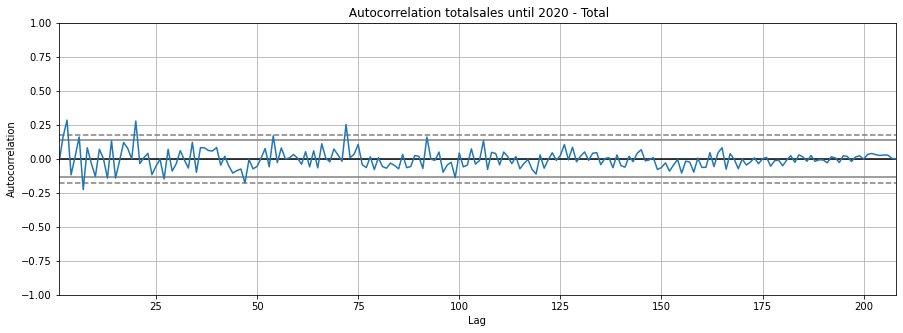

In [55]:
# Autocorrelation totalsales 2020
from pandas.plotting import autocorrelation_plot
plt.figure(figsize=(15,5))
autocorrelation_plot(df_newmodel.Gesamt['15.03.2020':]).set_title(" Autocorrelation totalsales until 2020 - Total")

plt.show()

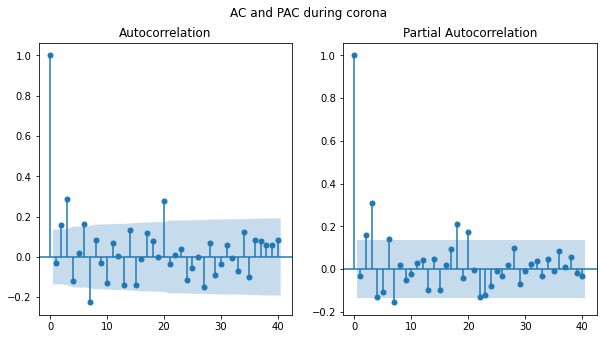

In [56]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('AC and PAC during corona')
sm.graphics.tsa.plot_acf(df_newmodel.Gesamt['15.03.2020':].squeeze(), lags=40, ax=ax1)
sm.graphics.tsa.plot_pacf(df_newmodel.Gesamt['15.03.2020':].squeeze(), lags=40, ax=ax2)
plt.show()

# Checks Timeseries Filiale 1

In [18]:
df_newmodel_1 = df_new_1.copy().set_index('Datum')

## Exploration  in total

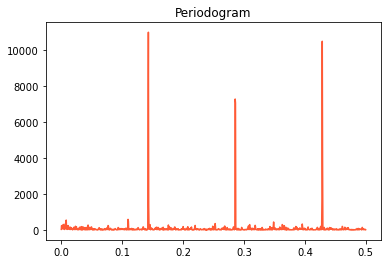

In [19]:
# We use for the sampling frequency 1 as we want to
# discover cycles over the original time steps.
f, Pxx = signal.periodogram(df_newmodel_1.Gesamt, fs = 1, window='hanning', scaling='spectrum')
plt.plot(f, Pxx, color = NF_ORANGE)
plt.title('Periodogram')
plt.show()

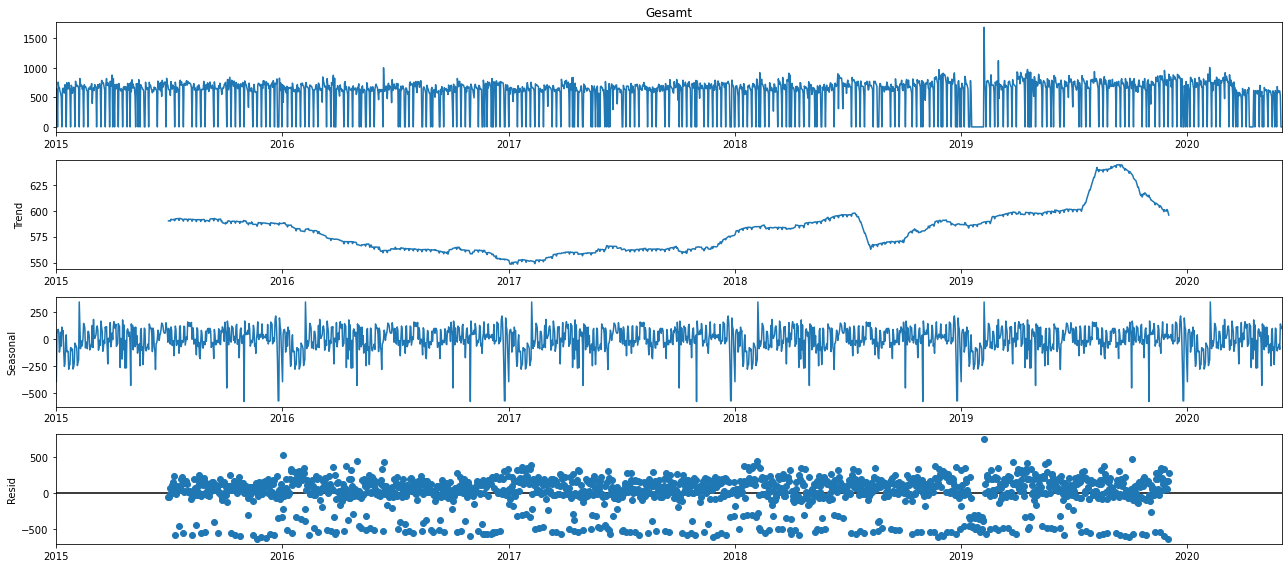

In [21]:
Jahr = 2020
#Decomposition for Filiale 1
y = df_newmodel_1[df_newmodel_1.index.year <= Jahr].Gesamt

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='aditive',period=365)
fig = decomposition.plot()
       
plt.show()

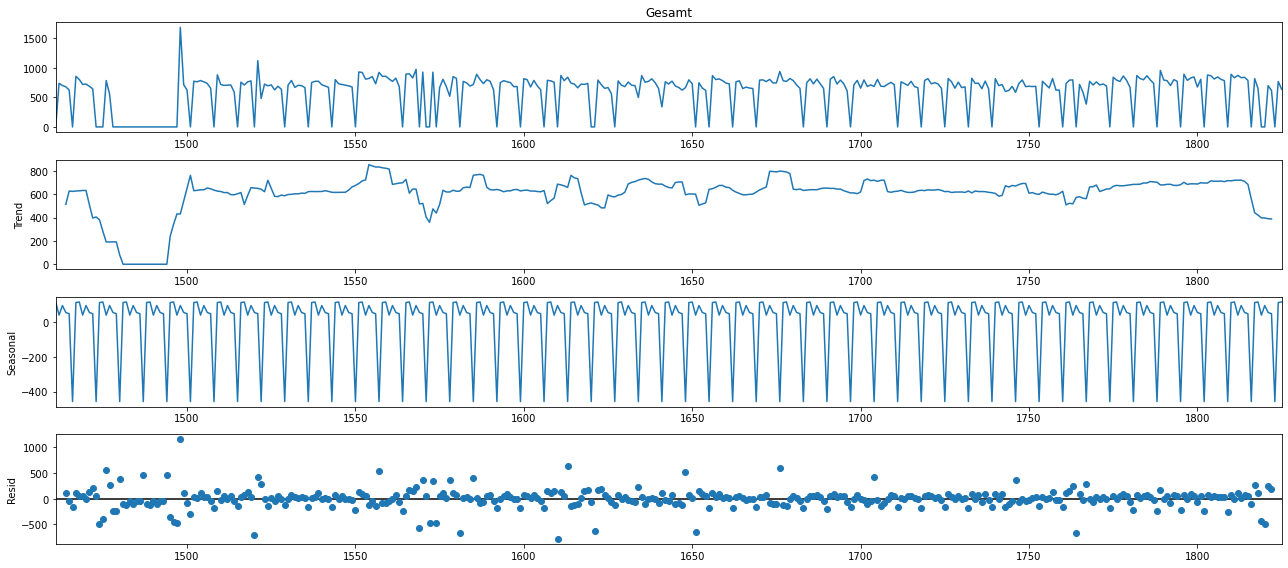

In [23]:
Jahr = 2019
#for idx,fil in enumerate([df_new_1,df_new_2,df_new_3],1):
y = df_new_1[df_newmodel_1.index.year == Jahr].Gesamt
#sum(axis=1)
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive',period=7)
fig = decomposition.plot()
       
plt.show()

### Analysis on Articlegroups

#### Weizenbrot

**Conclusions**
- `The is a longterm trend which can be seen for period=365. The sales volumne decreases over the years.`
-  `There is a weekly and yearly saisonality.`

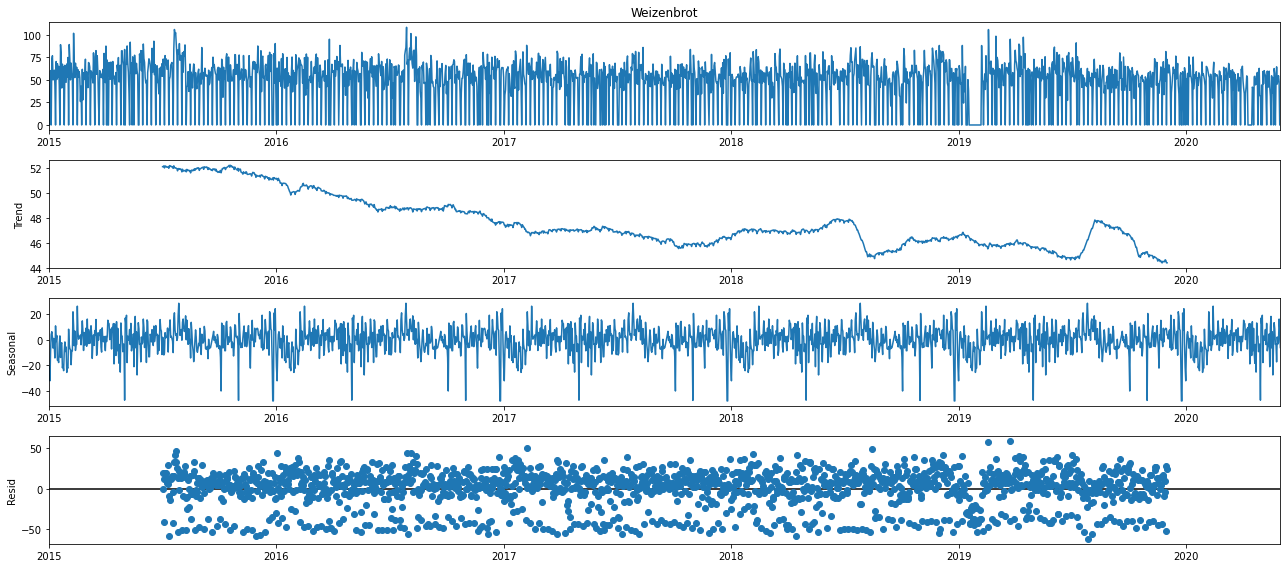

In [26]:
Jahr = 2019
#Decomposition for Filiale 1
y = df_newmodel_1[df_newmodel_1.index.year <= 2020].Weizenbrot

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='aditive',period=365)
fig = decomposition.plot()
       
plt.show()

#### Mischbrot

**Conclusions**
- `The is a longterm trend which can be seen for period=365. The sales volumne increases over the years.`
- `There is a weekly and yearly saisonality.`

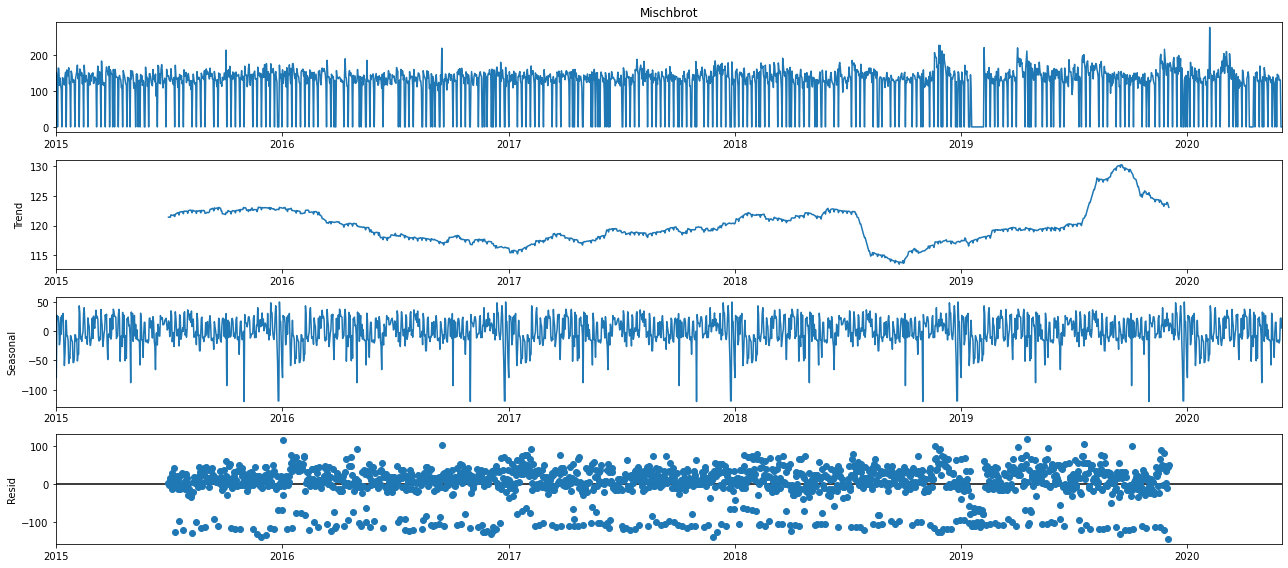

In [27]:
Jahr = 2020
#Decomposition for Filiale 1
y = df_newmodel_1[df_newmodel_1.index.year <= Jahr].Mischbrot

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='aditive',period=365)
fig = decomposition.plot()
       
plt.show()

#### Vollkornbrot

**Conclusions**
- `The is a longterm trend which can be seen for period=365. The sales volumne increases over the years.`
- `There is a weekly saisonality which means period=7.`

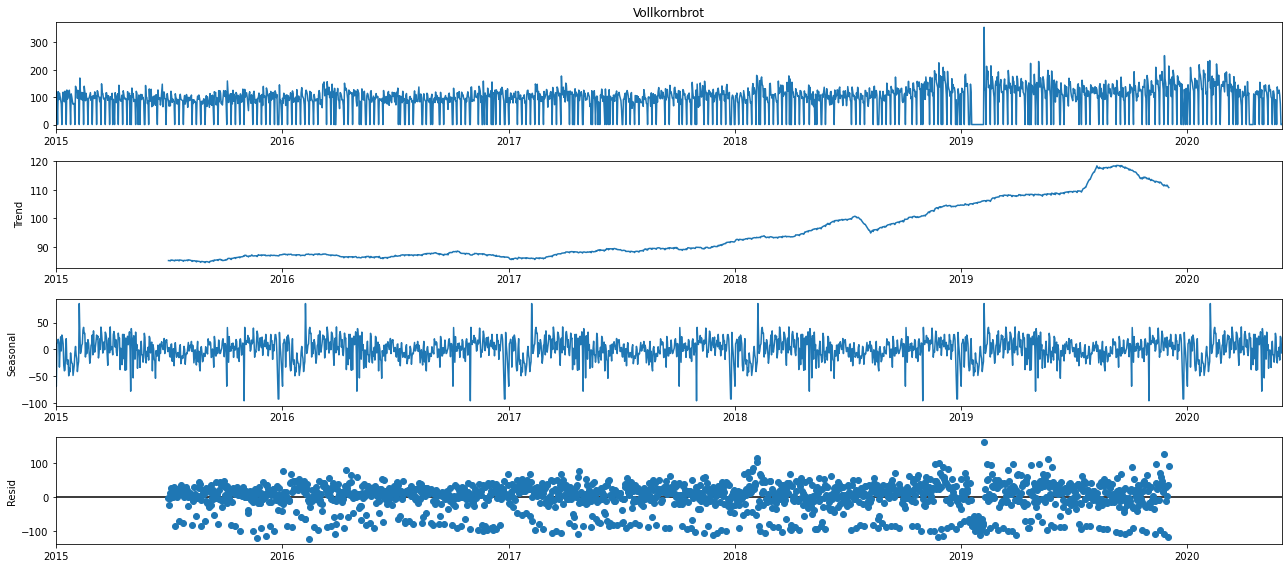

In [28]:
Jahr = 2020
#Decomposition for Filiale 1
y = df_newmodel_1[df_newmodel_1.index.year <= Jahr].Vollkornbrot

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='aditive',period=365)
fig = decomposition.plot()
       
plt.show()

#### Spezialbrot

**Conclusions**
- `After the launch of the product in 2016 the sales volumne is relativly contant over the years.`
- `There is a weekly and yearly saisonality.`

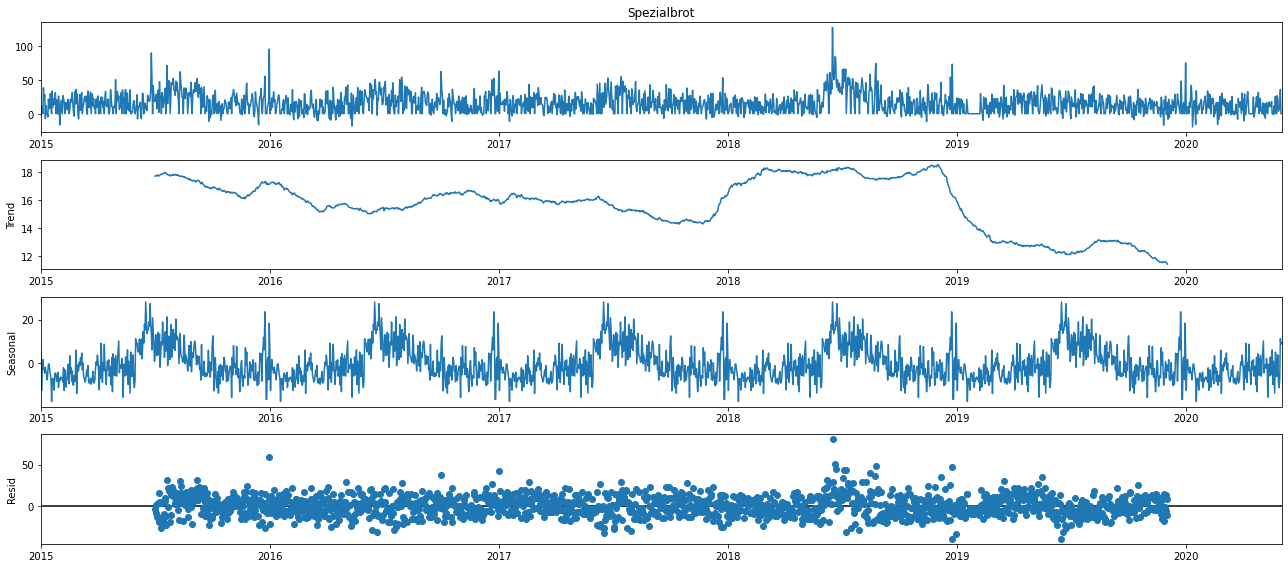

In [29]:
Jahr = 2020
#Decomposition for Filiale 1
y = df_newmodel_1[df_newmodel_1.index.year <= Jahr].Spezialbrot

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='aditive',period=365)
fig = decomposition.plot()
       
plt.show()

#### Stangenbrot

**Conclusions**
- `The is a trend which can be seen for period=365. The sales volumne first increases until 2018 and than increase.`
- `There is a weekly and yearly saisonality.`

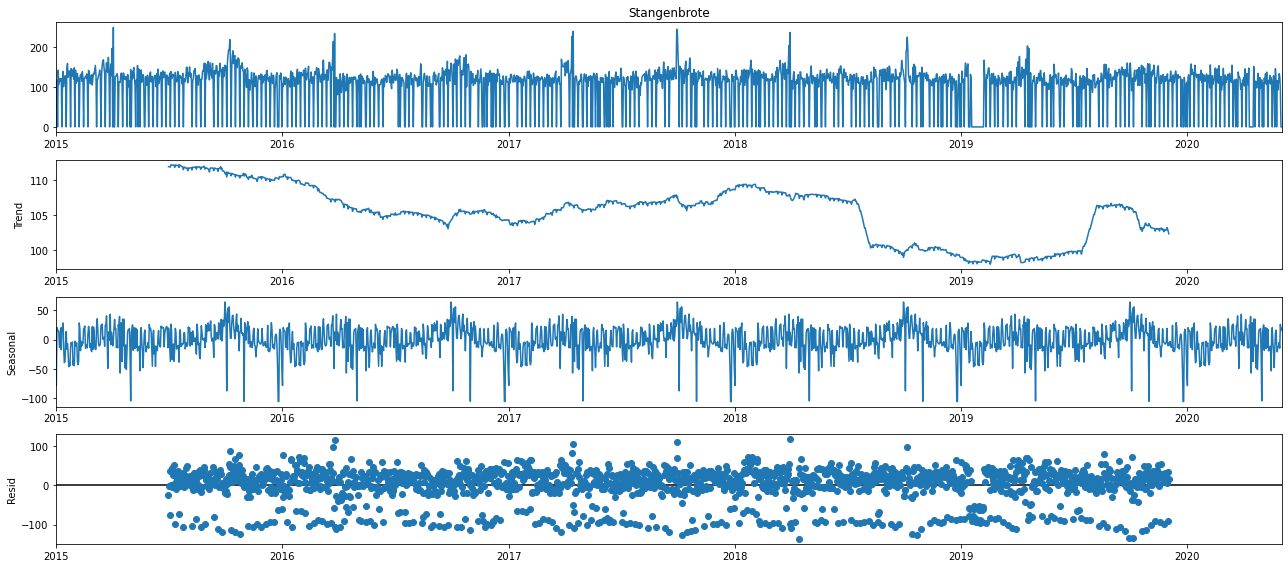

In [31]:
Jahr = 2020
#Decomposition for Filiale 1
y = df_newmodel_1[df_newmodel_1.index.year <= Jahr].Stangenbrote

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='aditive',period=365)
fig = decomposition.plot()
       
plt.show()

#### Brötchen

**Conclusions**
- `The is a longterm trend which can be seen for period=365. The sales volumne increases over the last 3 years.`
- `There is a weekly saisonality which means period=7.`

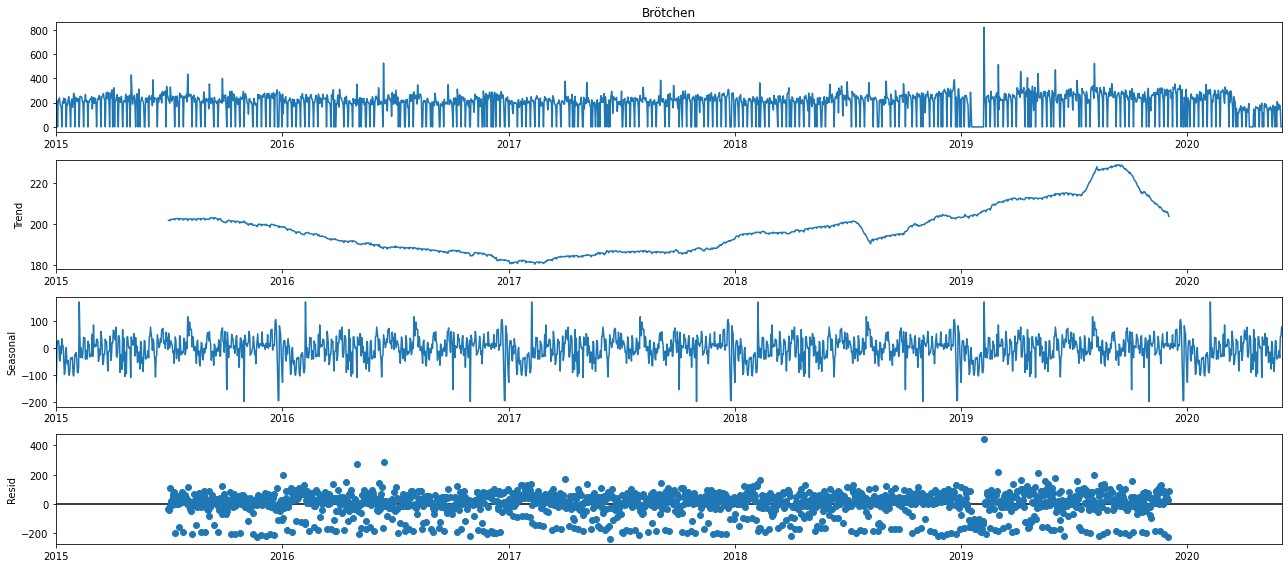

In [32]:
Jahr = 2020
#Decomposition for Filiale 1
y = df_newmodel_1[df_newmodel_1.index.year <= Jahr].Brötchen

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='aditive',period=365)
fig = decomposition.plot()
       
plt.show()

#### Süsse Brötchen

**Conclusions**
- `The is a longterm trend which can be seen for period=365. The sales volumne increases over the last 3 years. The plots look very similar to those of previous articlegroup Brötchen.`
- `There are weekly and yearly patterns.`

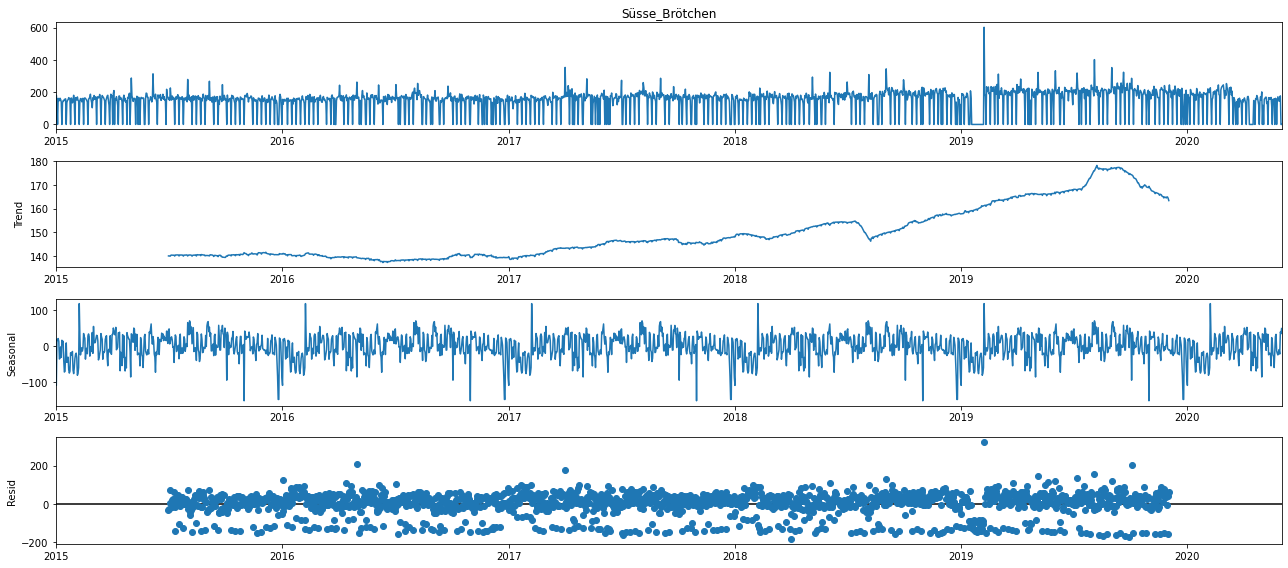

In [34]:
Jahr = 2020
#Decomposition for Filiale 1
y = df_newmodel_1[df_newmodel_1.index.year <= Jahr].Süsse_Brötchen

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='aditive',period=365)
fig = decomposition.plot()
       
plt.show()

#### Herzhafte Brötchen

**Conclusions**
- `The is a longterm trend which can be seen for period=365. The sales volumne increases over the last 3 years. The plots look very similar to those of previous articlegroups Brötchen an Süsse_Brötchen.`


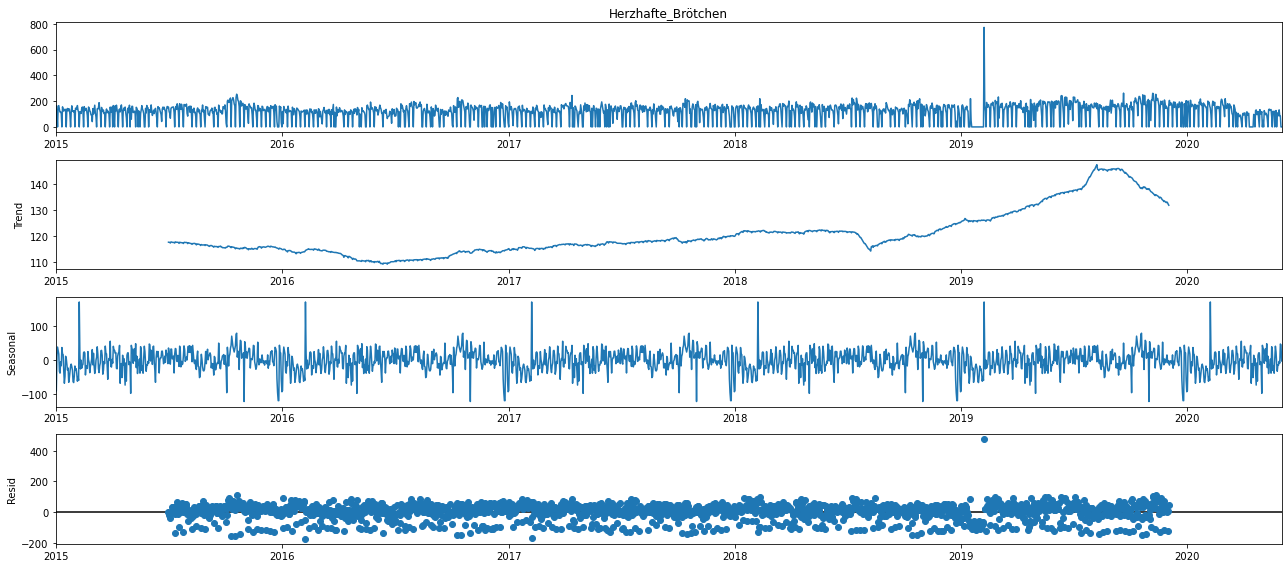

In [35]:
Jahr = 2020
#Decomposition for Filiale 1
y = df_newmodel_1[df_newmodel_1.index.year <= Jahr].Herzhafte_Brötchen

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='aditive',period=365)
fig = decomposition.plot()
       
plt.show()

#### KonditoreiBlech

**Conclusions**
- `The is a longterm trend which can be seen for period=365. The sales volumne decreases since 2017. The plots look very similar to those of previous articlegroups Brötchen an Süsse_Brötchen.`
-`There are weekly and yearly patterns within the data.`


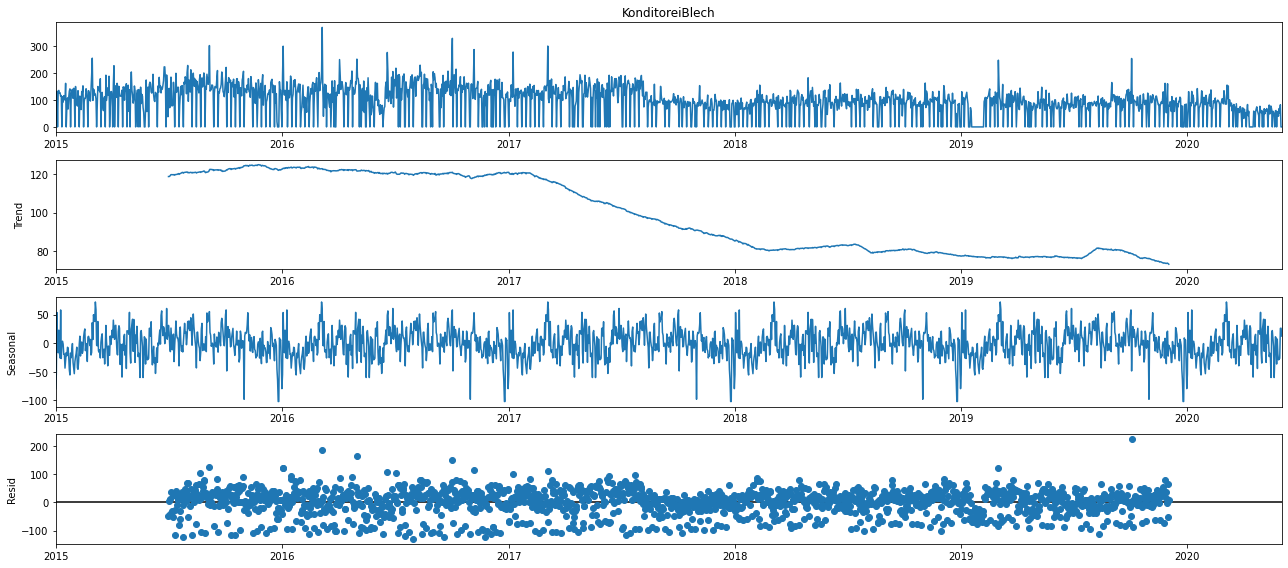

In [36]:
Jahr = 2020
#Decomposition for Filiale 1
y = df_newmodel_1[df_newmodel_1.index.year <= Jahr].KonditoreiBlech

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='aditive',period=365)
fig = decomposition.plot()
       
plt.show()

#### Stückgebäck

**Conclusions**

- `You can see peaks for every New Year's Eve. Inspite of this peaks, the values are rel. constant over the years.`
- `There are weak weekly and yearly patterns within the data.`


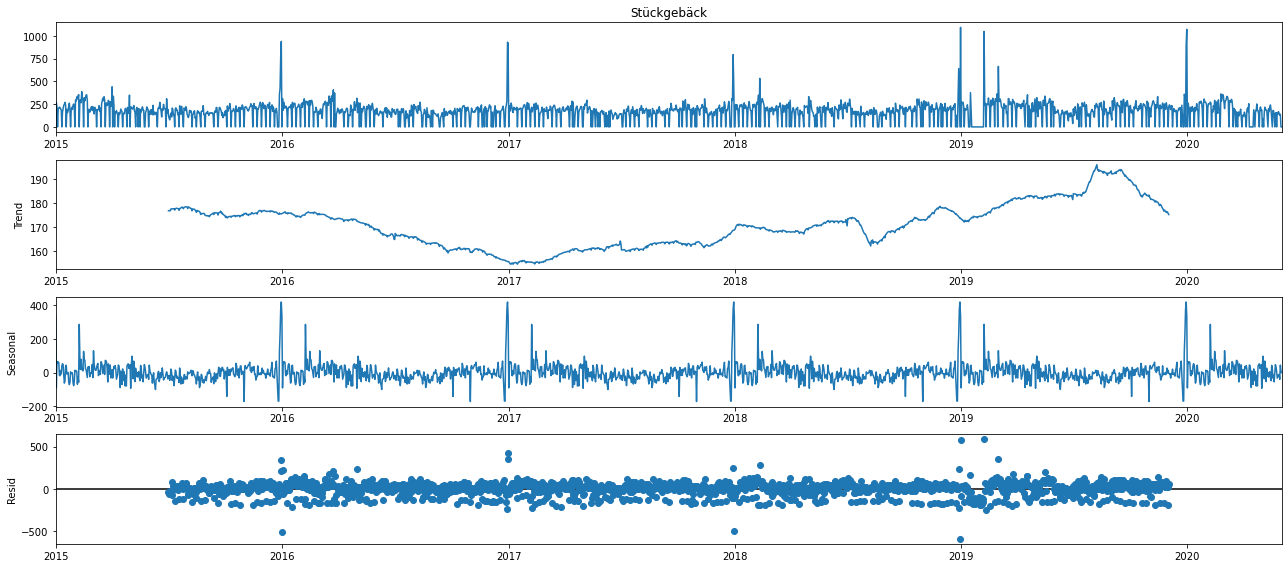

In [37]:
Jahr = 2020
#Decomposition for Filiale 1
y = df_newmodel_1[df_newmodel_1.index.year <= Jahr].Stückgebäck

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='aditive',period=365)
fig = decomposition.plot()
       
plt.show()

#### Blechkuchen

**Conclusions**
- `The is a longterm trend which can be seen for period=365. The sales volumne increases since 2018.`
- `There are weekly and yearly patterns within the data.`


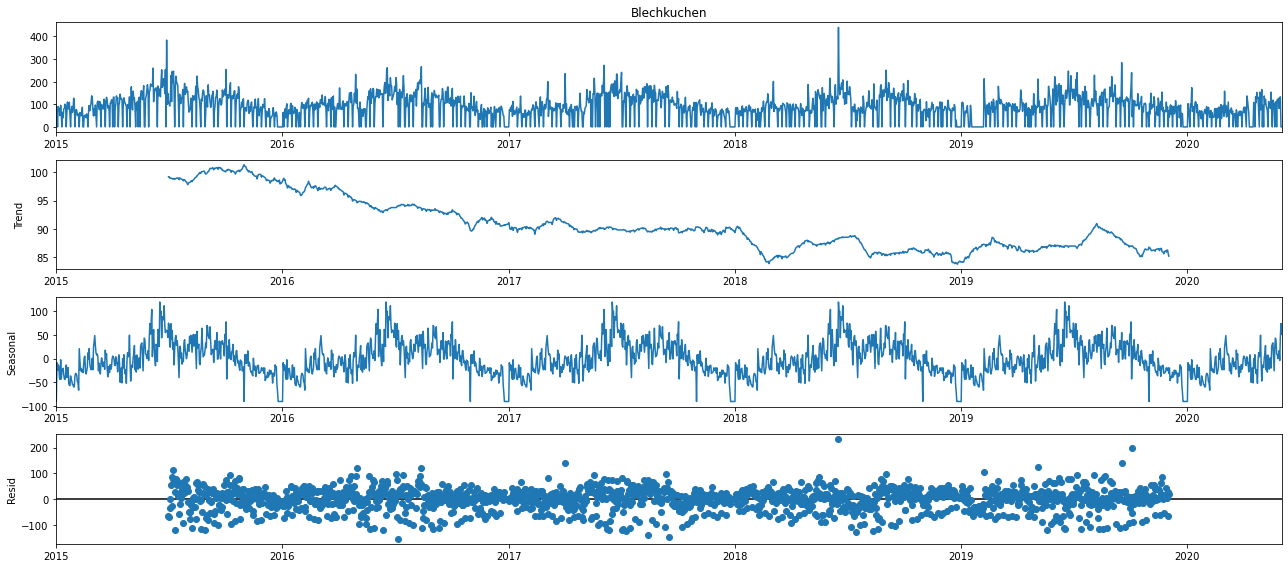

In [38]:
Jahr = 2020
#Decomposition for Filiale 1
y = df_newmodel_1[df_newmodel_1.index.year <= Jahr].Blechkuchen

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='aditive',period=365)
fig = decomposition.plot()
       
plt.show()

#### Weihnachtsartikel

**Conclusions**
- `The is a longterm trend which can be seen for period=365. The sales volumne increases since 2017.`
- `There are hugh yearly patterns within the data, which does not surprise.`


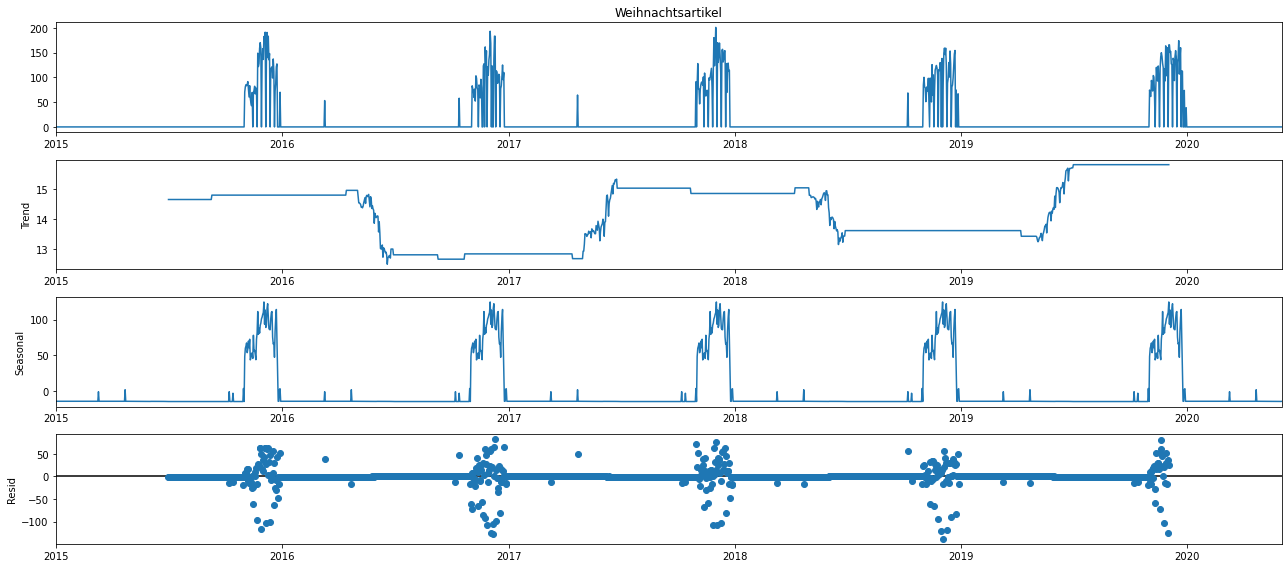

In [39]:
Jahr = 2020
#Decomposition for Filiale 1
y = df_newmodel_1[df_newmodel_1.index.year <= Jahr].Weihnachtsartikel

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='aditive',period=365)
fig = decomposition.plot()
       
plt.show()

## Lag Plots

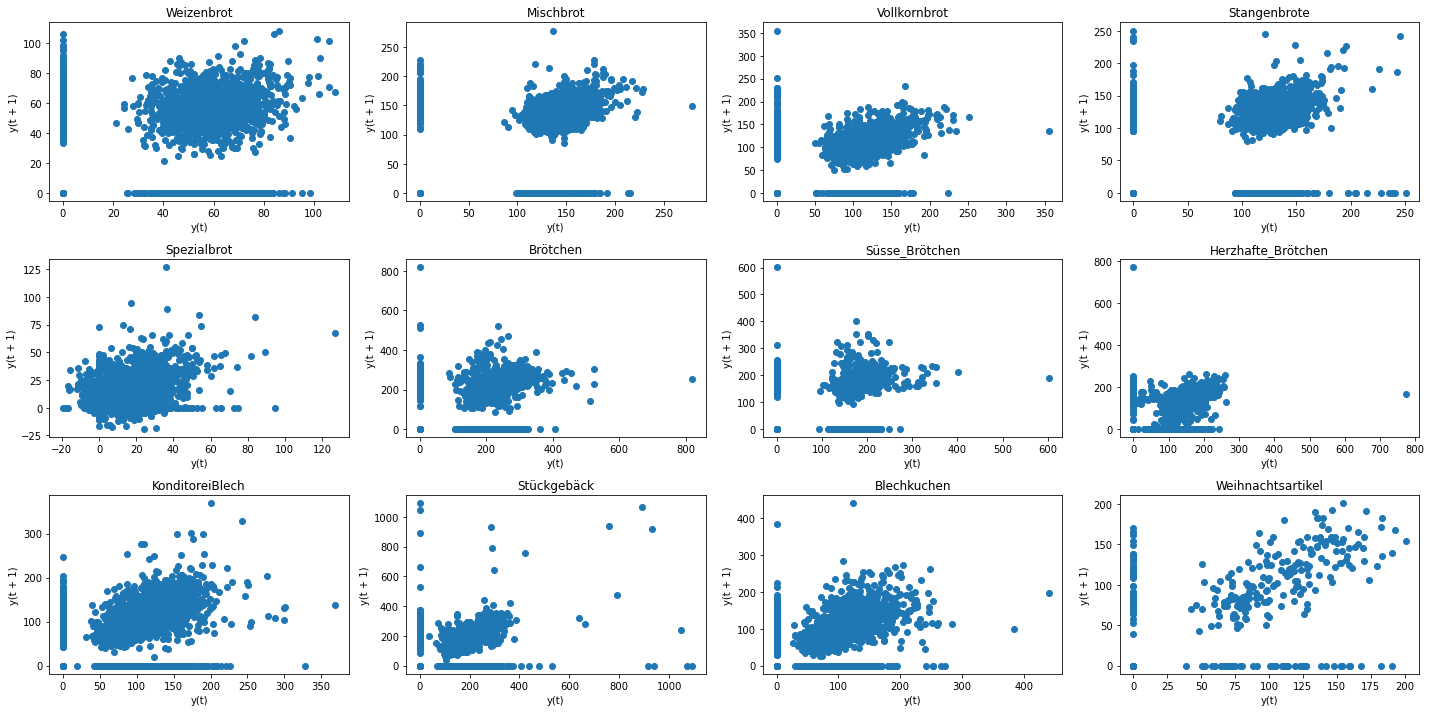

In [40]:
# Make the graph 20 inches by 10 inches
plt.figure(figsize=(20,10), facecolor='white')

# plot numbering starts at 1, not 0
plot_number = 1
for name in df_basis_1.columns:

    ax = plt.subplot(3, 4, plot_number)
    lag_plot(df_basis_1['%s' % (name)],ax=ax)
    ax.set_title(name)
    # Go to the next plot for the next loop
    plot_number = plot_number + 1
plt.tight_layout()

## Autocorrelation Plots

### for Filiale 1

**Conclusions**
- `From the plot you can see there is a high peak in correlation at the lag of 7th day, then again on the 14th day
and so on. The series is perfectly autocorrelated with a lag of 1 week.`
- `This is valid for all single articlegroups with the exception Weihnachtsartikel. See single plots.`
- `For all articlegroups except Brot(Vollkornbrot, Weizenbrot,..) you see a  peak in correlation at the lag of 365th day.`


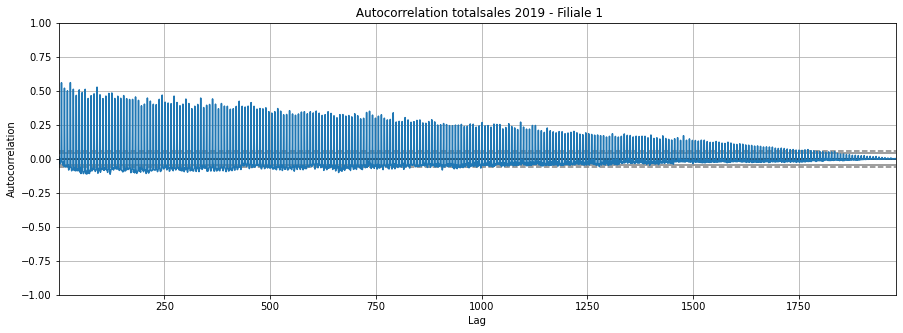

In [57]:
# Autocorrelation totalsales  - Filiale 1
from pandas.plotting import autocorrelation_plot
plt.figure(figsize=(15,5))
autocorrelation_plot(df_new_1.Gesamt).set_title(" Autocorrelation totalsales 2019 - Filiale 1")
plt.show()

In [ ]:
#fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,5))
#fig.suptitle('AC and PAC for Filiale 2')
#sm.graphics.tsa.plot_acf(df_new_2.Gesamt.squeeze(), lags=20, ax=ax1)
#sm.graphics.tsa.plot_pacf(df_new_2.Gesamt.squeeze(), lags=20, ax=ax2)
#plt.show()


### for Filiale 1 on Articlegroups

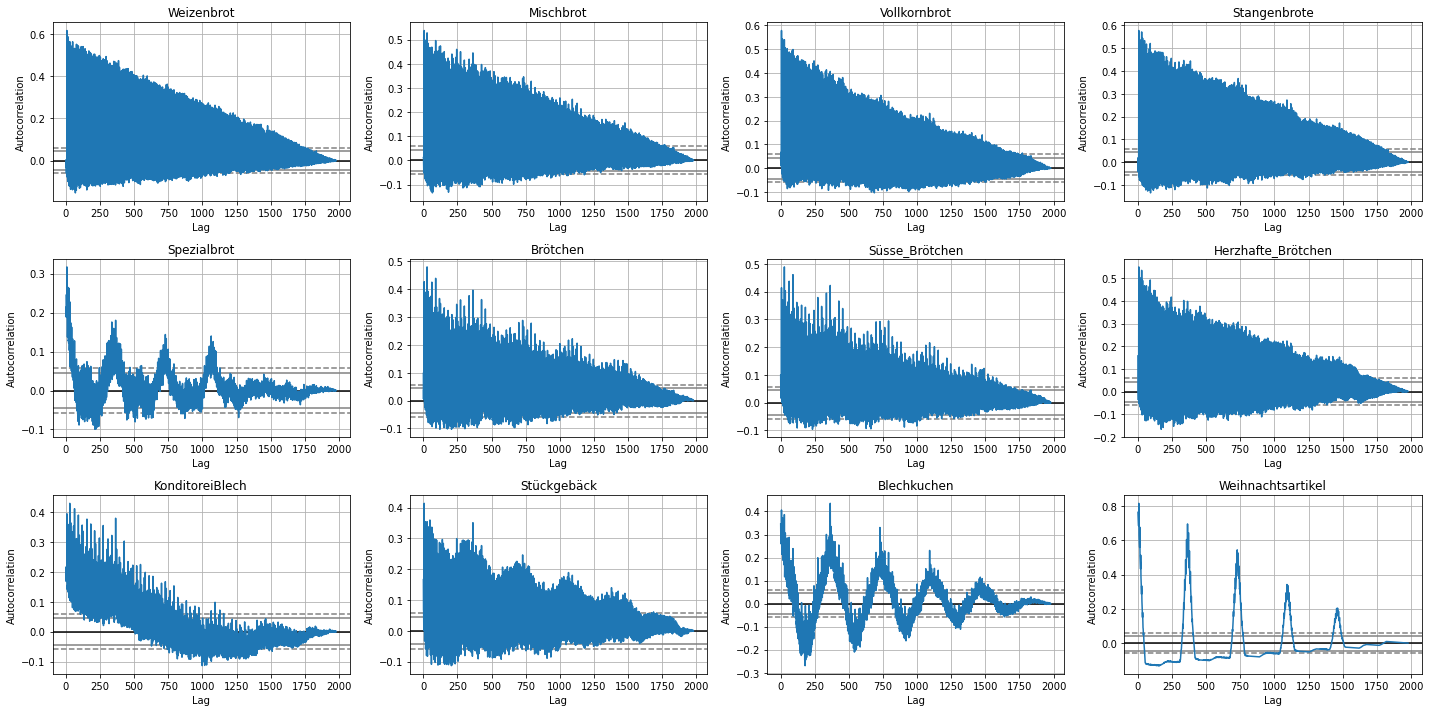

In [44]:
# Analyse weekly dependencies
plt.figure(figsize=(20,10), facecolor='white')

# plot numbering starts at 1, not 0
plot_number = 1
for name in df_basis_1.columns:

    ax = plt.subplot(3, 4, plot_number)
    autocorrelation_plot(df_basis_1['%s' % (name)],ax=ax)
    ax.set_title(name)
    # Go to the next plot for the next loop
    plot_number = plot_number + 1
plt.tight_layout()

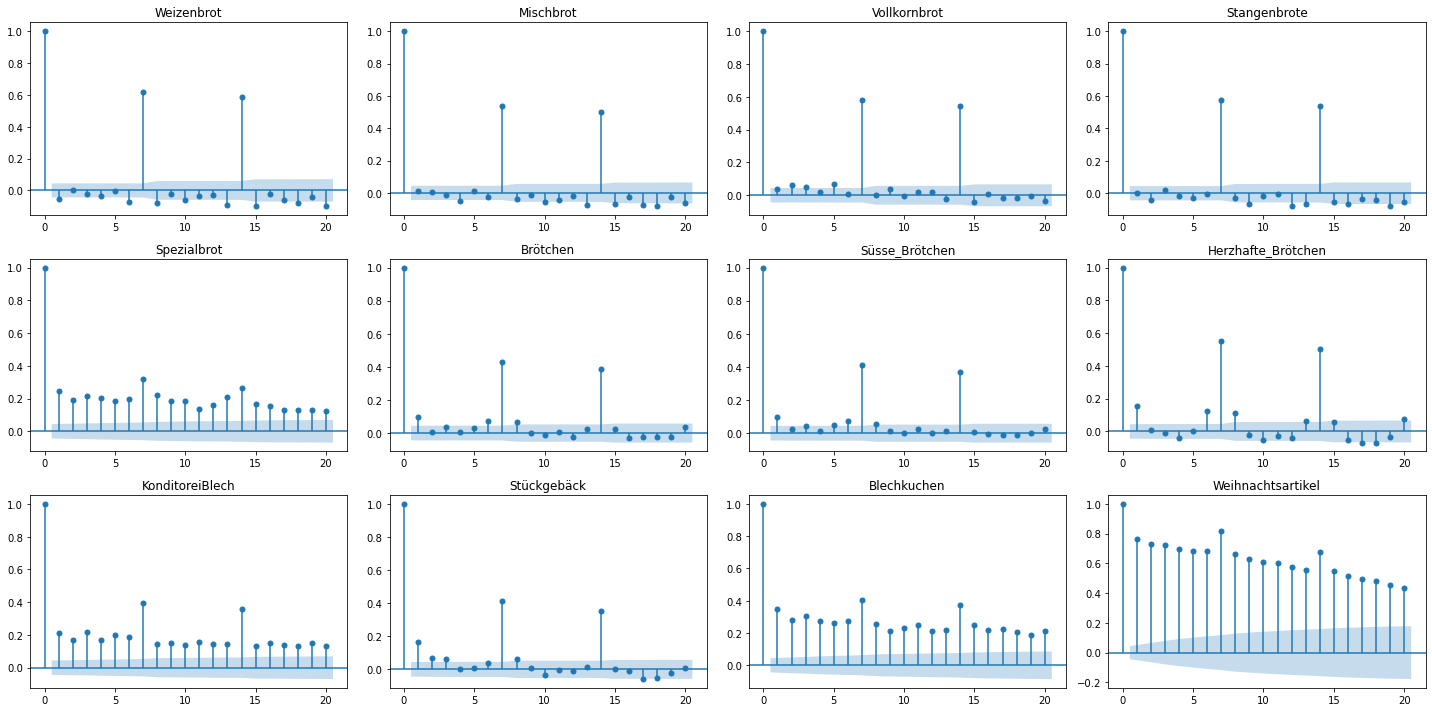

In [45]:
# Analyse weekly dependencies - ACF
plt.figure(figsize=(20,10), facecolor='white')

# plot numbering starts at 1, not 0
plot_number = 1
for name in df_basis_1.columns:

    ax = plt.subplot(3, 4, plot_number)
    plot_acf(df_basis_1['%s' % (name)],lags=20,ax=ax)
    ax.set_title(name)
    # Go to the next plot for the next loop
    plot_number = plot_number + 1
plt.tight_layout()

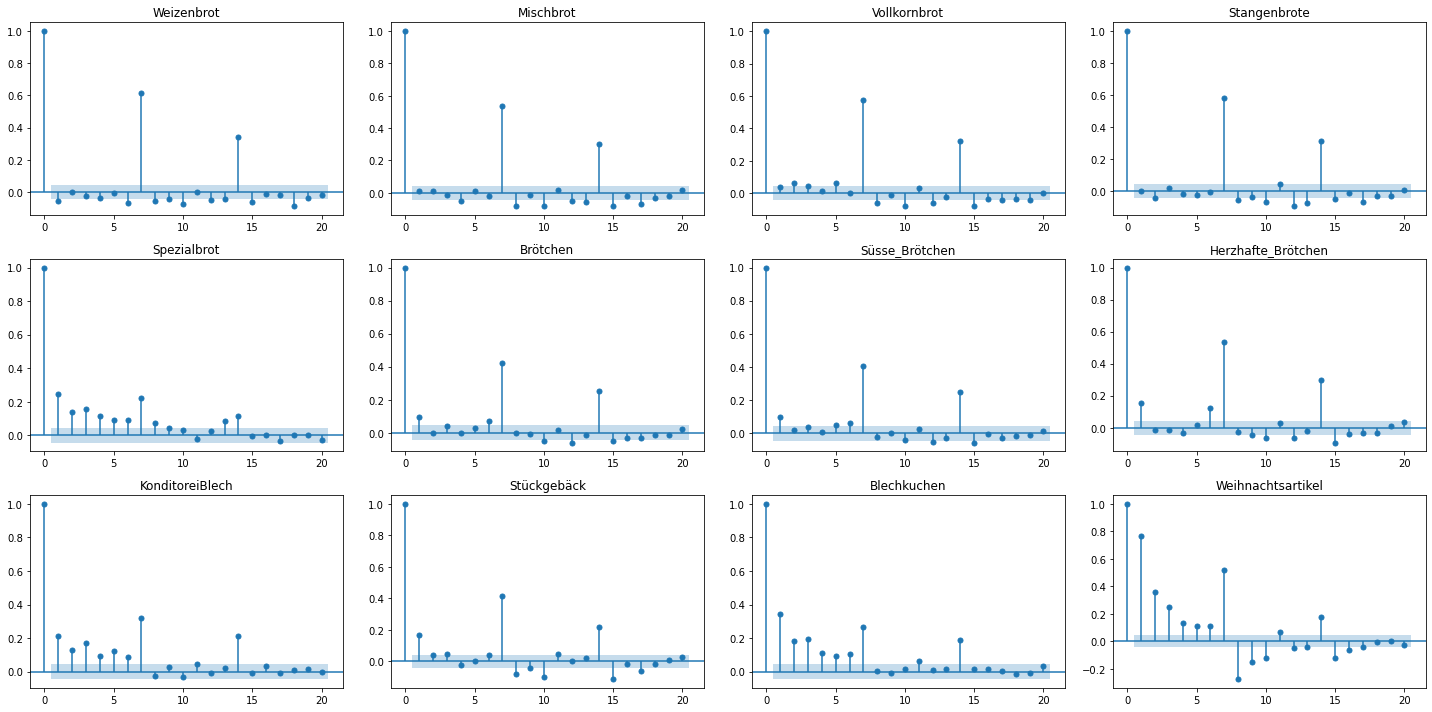

In [46]:
# Analyse weekly dependencies - PACF
plt.figure(figsize=(20,10), facecolor='white')

# plot numbering starts at 1, not 0
plot_number = 1
for name in df_basis_1.columns:

    ax = plt.subplot(3, 4, plot_number)
    plot_pacf(df_basis_1['%s' % (name)],lags=20,ax=ax)
    ax.set_title(name)
    # Go to the next plot for the next loop
    plot_number = plot_number + 1
plt.tight_layout()

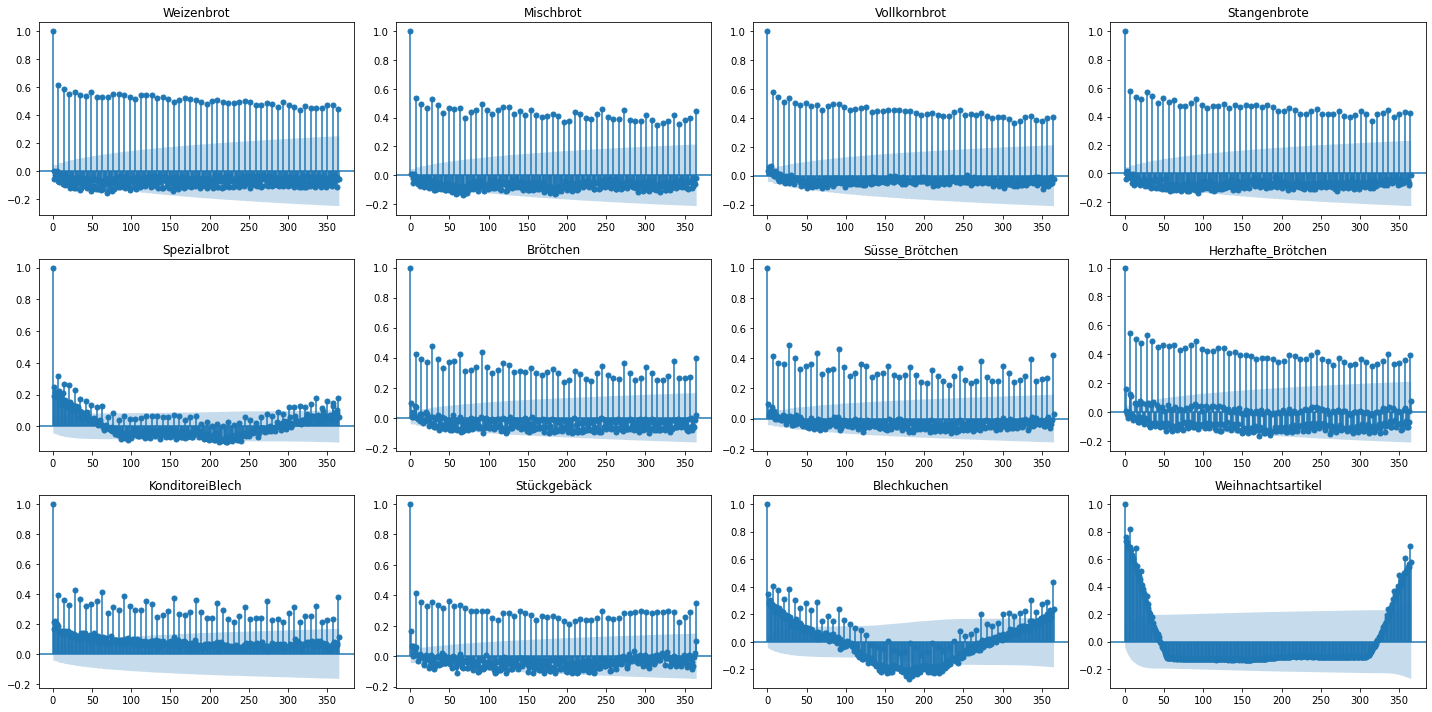

In [47]:
# Analyse yearly dependencies - ACF
plt.figure(figsize=(20,10), facecolor='white')

# plot numbering starts at 1, not 0
plot_number = 1
for name in df_basis_1.columns:

    ax = plt.subplot(3, 4, plot_number)
    plot_acf(df_basis_1['%s' % (name)],lags=365,ax=ax)
    ax.set_title(name)
    # Go to the next plot for the next loop
    plot_number = plot_number + 1
plt.tight_layout()

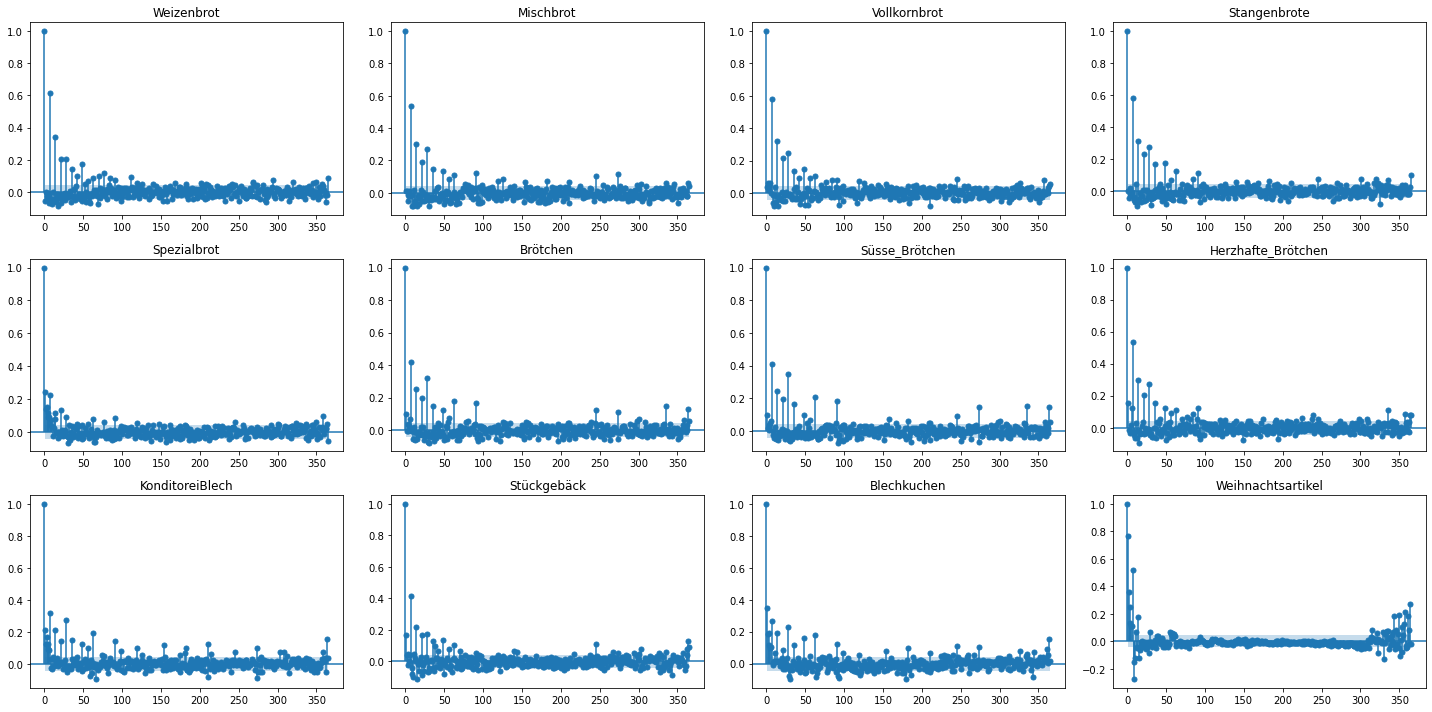

In [48]:
# Analyse yearly dependencies - PACF
plt.figure(figsize=(20,10), facecolor='white')

# plot numbering starts at 1, not 0
plot_number = 1
for name in df_basis_1.columns:

    ax = plt.subplot(3, 4, plot_number)
    plot_pacf(df_basis_1['%s' % (name)],lags=365,ax=ax)
    ax.set_title(name)
    # Go to the next plot for the next loop
    plot_number = plot_number + 1
plt.tight_layout()

## Check Stationarity

**Conclusions**
- `The following series are stationary: Weizenbrot, Mischbrot, Stangenbrote, Spezialbrot, Stückgebäck und Blechkuchen. To use VARIMA/VARIMAX  all of the Series needs to be stationary.`
- `After 1 time differentiation all of  the series are difference-stationary / Typ I(1).`



In [58]:
# Augmented Dickey-Fuller Test (ADF Test)/unit root test short
from statsmodels.tsa.stattools import adfuller
def adf_test_long(ts, signif=0.05):
    dftest = adfuller(ts, autolag='AIC',maxlag=365)
    adf = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags','# Observations'])
    for key,value in dftest[4].items():
       adf['Critical Value (%s)'%key] = value
     
    p = adf['p-value']
    if p <= signif:
        pass
        #print(f" Series is Stationary")
        
    else:
        print(f"Ergebnis für Timeseries {name}:")
        print (adf)
        print(f" Series is Non-Stationary")


In [59]:
def adf_test_long_einzel(ts, signif=0.05):
    dftest = adfuller(ts, autolag='AIC',maxlag=365)
    adf = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags','# Observations'])
    for key,value in dftest[4].items():
       adf['Critical Value (%s)'%key] = value
     
    p = adf['p-value']
    if p <= signif:
        pass
        print(f" Series is Stationary")
        print (adf)
    else:
        print(f"Ergebnis für Timeseries:")
        print (adf)
        print(f" Series is Non-Stationary")


In [67]:
# Augmented Dickey-Fuller Test (ADF Test)/unit root test
from statsmodels.tsa.stattools import adfuller
def adf_test(ts, signif=0.05):
    dftest = adfuller(ts, autolag='AIC',maxlag=365)
    adf = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags','# Observations'])
    for key,value in dftest[4].items():
       adf['Critical Value (%s)'%key] = value
    
    p = adf['p-value']
    if p <= signif:
        pass
        print(f" Ergebnis für Timeseries {name}: Series is Stationary")
    else: 
        print(f"Ergebnis für Timeseries {name}: Series is Non-Stationary")
        #print (adf)
        
#apply adf test on the series

In [60]:
#Apply Check to timeseries of Filiale 1
for name in df_basis_1.columns:
    adf_test_long(df_basis_1[name])
    

Ergebnis für Timeseries Vollkornbrot:
Test Statistic            -2.733711
p-value                    0.068384
# Lags                    92.000000
# Observations          1886.000000
Critical Value (1%)       -3.433822
Critical Value (5%)       -2.863074
Critical Value (10%)      -2.567586
dtype: float64
 Series is Non-Stationary
Ergebnis für Timeseries Brötchen:
Test Statistic            -2.307098
p-value                    0.169689
# Lags                    92.000000
# Observations          1886.000000
Critical Value (1%)       -3.433822
Critical Value (5%)       -2.863074
Critical Value (10%)      -2.567586
dtype: float64
 Series is Non-Stationary
Ergebnis für Timeseries Süsse_Brötchen:
Test Statistic            -2.656644
p-value                    0.081846
# Lags                    92.000000
# Observations          1886.000000
Critical Value (1%)       -3.433822
Critical Value (5%)       -2.863074
Critical Value (10%)      -2.567586
dtype: float64
 Series is Non-Stationary
Ergebnis 

In [68]:
#Apply Check to timeseries of Filiale 1
for name in df_basis_1.columns:
    adf_test(df_basis_1[name])
    

 Ergebnis für Timeseries Weizenbrot: Series is Stationary
 Ergebnis für Timeseries Mischbrot: Series is Stationary
Ergebnis für Timeseries Vollkornbrot: Series is Non-Stationary
 Ergebnis für Timeseries Stangenbrote: Series is Stationary
 Ergebnis für Timeseries Spezialbrot: Series is Stationary
Ergebnis für Timeseries Brötchen: Series is Non-Stationary
Ergebnis für Timeseries Süsse_Brötchen: Series is Non-Stationary
Ergebnis für Timeseries Herzhafte_Brötchen: Series is Non-Stationary
Ergebnis für Timeseries KonditoreiBlech: Series is Non-Stationary
 Ergebnis für Timeseries Stückgebäck: Series is Stationary
 Ergebnis für Timeseries Blechkuchen: Series is Stationary
Ergebnis für Timeseries Weihnachtsartikel: Series is Non-Stationary


In [72]:
#Apply Check to the diff of the timeseries of Filiale 1
adf_test_long_einzel(df_basis_1.Vollkornbrot.diff().dropna())

 Series is Stationary
Test Statistic         -7.224151e+00
p-value                 2.074060e-10
# Lags                  9.100000e+01
# Observations          1.886000e+03
Critical Value (1%)    -3.433822e+00
Critical Value (5%)    -2.863074e+00
Critical Value (10%)   -2.567586e+00
dtype: float64


In [74]:
adf_test_long_einzel(df_basis_1.Brötchen.diff().dropna())

 Series is Stationary
Test Statistic         -7.515123e+00
p-value                 3.921678e-11
# Lags                  9.100000e+01
# Observations          1.886000e+03
Critical Value (1%)    -3.433822e+00
Critical Value (5%)    -2.863074e+00
Critical Value (10%)   -2.567586e+00
dtype: float64


In [75]:
adf_test_long_einzel(df_basis_1.Süsse_Brötchen.diff().dropna())

 Series is Stationary
Test Statistic         -7.547548e+00
p-value                 3.253233e-11
# Lags                  9.100000e+01
# Observations          1.886000e+03
Critical Value (1%)    -3.433822e+00
Critical Value (5%)    -2.863074e+00
Critical Value (10%)   -2.567586e+00
dtype: float64


In [76]:
adf_test_long_einzel(df_basis_1.Herzhafte_Brötchen.diff().dropna())

 Series is Stationary
Test Statistic         -7.037632e+00
p-value                 5.959200e-10
# Lags                  9.200000e+01
# Observations          1.885000e+03
Critical Value (1%)    -3.433824e+00
Critical Value (5%)    -2.863075e+00
Critical Value (10%)   -2.567587e+00
dtype: float64


In [77]:
adf_test_long_einzel(df_basis_1.KonditoreiBlech.diff().dropna())

 Series is Stationary
Test Statistic            -3.969605
p-value                    0.001578
# Lags                   209.000000
# Observations          1768.000000
Critical Value (1%)       -3.434054
Critical Value (5%)       -2.863176
Critical Value (10%)      -2.567641
dtype: float64


In [78]:
adf_test_long_einzel(df_basis_1.Weihnachtsartikel.diff().dropna())

 Series is Stationary
Test Statistic         -1.479274e+01
p-value                 2.158681e-27
# Lags                  3.650000e+02
# Observations          1.612000e+03
Critical Value (1%)    -3.434413e+00
Critical Value (5%)    -2.863335e+00
Critical Value (10%)   -2.567725e+00
dtype: float64


## Check Causality

**Conclusions**
- `Looking at the p-Values we can assume that almost all variables are interchangeably each user.`
- `A exception is the articlegroup Blechkuchen.`
- `Overall this justifies an multivariate approach for prediction.`

In [79]:
maxlag=12
test = 'ssr-chi2test'

def grangers_causality_matrix(X_train, variables,Filiale, test = 'ssr_chi2test', verbose=False):
   dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
   for c in dataset.columns:
    for r in dataset.index:
        test_result = grangercausalitytests(X_train[[r,c]], maxlag=maxlag, verbose=False)
        p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
        if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
        min_p_value = np.min(p_values)
        dataset.loc[r,c] = min_p_value
        
    dataset.columns = [var + '_x_'+ Filiale for var in variables]
    dataset.index = [var + '_y' for var in variables]

    return dataset


In [86]:
df_basisnew_1=df_newmodel_1.iloc[:,0:12]

In [87]:
result_1=grangers_causality_matrix(df_basisnew_1, df_basisnew_1.columns,Filiale='Filiale_2')
result_1

Weizenbrot_x_Filiale_2  Mischbrot_x_Filiale_2  \
Weizenbrot_y                             1.0                    0.0   
Mischbrot_y                              0.0                    0.0   
Vollkornbrot_y                           0.0                    0.0   
Stangenbrote_y                           0.0                    0.0   
Spezialbrot_y                            0.0                    0.0   
Brötchen_y                               0.0                    0.0   
Süsse_Brötchen_y                         0.0                    0.0   
Herzhafte_Brötchen_y                     0.0                    0.0   
KonditoreiBlech_y                        0.0                    0.0   
Stückgebäck_y                            0.0                    0.0   
Blechkuchen_y                            0.0                    0.0   
Weihnachtsartikel_y                      0.0                    0.0   

                      Vollkornbrot_x_Filiale_2  Stangenbrote_x_Filiale_2  \
Weizenbrot_y                               0.0                       0.0   
Mischbrot_y                                0.0                       0.0   
Vollkornbrot_y                             0.0                       0.0   
Stangenbrote_y                             0.0                       0.0   
Spezialbrot_y                              0.0                       0.0   
Brötchen_y                                 0.0                       0.0   
Süsse_Brötchen_y                           0.0                       0.0   
Herzhafte_Brötchen_y                       0.0                       0.0   
KonditoreiBlech_y                          0.0                       0.0   
Stückgebäck_y                              0.0                       0.0   
Blechkuchen_y                              0.0                       0.0   
Weihnachtsartikel_y                        0.0                       0.0   

                      Spezialbrot_x_Filiale_2  Brötchen_x_Filiale_2  \
Weizenbrot_y                              0.0                   0.0   
Mischbrot_y                               0.0                   0.0   
Vollkornbrot_y                            0.0                   0.0   
Stangenbrote_y                            0.0                   0.0   
Spezialbrot_y                             0.0                   0.0   
Brötchen_y                                0.0                   0.0   
Süsse_Brötchen_y                          0.0                   0.0   
Herzhafte_Brötchen_y                      0.0                   0.0   
KonditoreiBlech_y                         0.0                   0.0   
Stückgebäck_y                             0.0                   0.0   
Blechkuchen_y                             0.0                   0.0   
Weihnachtsartikel_y                       0.0                   0.0   

                      Süsse_Brötchen_x_Filiale_2  \
Weizenbrot_y                                 0.0   
Mischbrot_y                                  0.0   
Vollkornbrot_y                               0.0   
Stangenbrote_y                               0.0   
Spezialbrot_y                                0.0   
Brötchen_y                                   0.0   
Süsse_Brötchen_y                             0.0   
Herzhafte_Brötchen_y                         0.0   
KonditoreiBlech_y                            0.0   
Stückgebäck_y                                0.0   
Blechkuchen_y                                0.0   
Weihnachtsartikel_y                          0.0   

                      Herzhafte_Brötchen_x_Filiale_2  \
Weizenbrot_y                                     0.0   
Mischbrot_y                                      0.0   
Vollkornbrot_y                                   0.0   
Stangenbrote_y                                   0.0   
Spezialbrot_y                                    0.0   
Brötchen_y                                       0.0   
Süsse_Brötchen_y                                 0.0   
Herzhafte_Brötchen_y                             0.0   
Kond

## Cointegrationtest

In [88]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

### Filiale 2

In [89]:
cointegration_test(df_basisnew_1)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Weizenbrot ::  1539.41   > 311.1288  =>   True
Mischbrot ::  1246.37   > 263.2603  =>   True
Vollkornbrot ::  1034.86   > 219.4051  =>   True
Stangenbrote ::  836.16    > 179.5199  =>   True
Spezialbrot ::  662.36    > 143.6691  =>   True
Brötchen ::  505.94    > 111.7797  =>   True
Süsse_Brötchen ::  373.43    > 83.9383   =>   True
Herzhafte_Brötchen ::  254.79    > 60.0627   =>   True
KonditoreiBlech ::  145.2     > 40.1749   =>   True
Stückgebäck ::  71.25     > 24.2761   =>   True
Blechkuchen ::  34.62     > 12.3212   =>   True
Weihnachtsartikel ::  7.36      > 4.1296    =>   True


# Checks Timeseries Filiale 2

## Decompose weekly, monthly and yearly effects as well as trends

In [92]:
df_newmodel_2 = df_new_2.copy().set_index('Datum')

In [ ]:
#df_new_1_index=df_newmodel_1.set_index('Datum')
#df_new_2_index=df_newmodel_2.set_index('Datum')
#df_new_3_index=df_newmodel_1.set_index('Datum')

### Exploration for Filiale 2

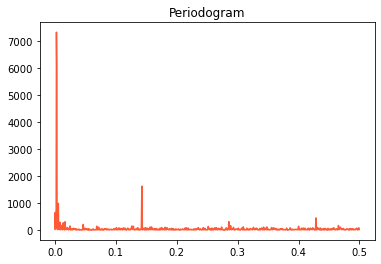

In [355]:
# We use for the sampling frequency 1 as we want to
# discover cycles over the original time steps.
f, Pxx = signal.periodogram(df_newmodel_2.Gesamt, fs = 1, window='hanning', scaling='spectrum')
plt.plot(f, Pxx, color = NF_ORANGE)
plt.title('Periodogram')
plt.show()

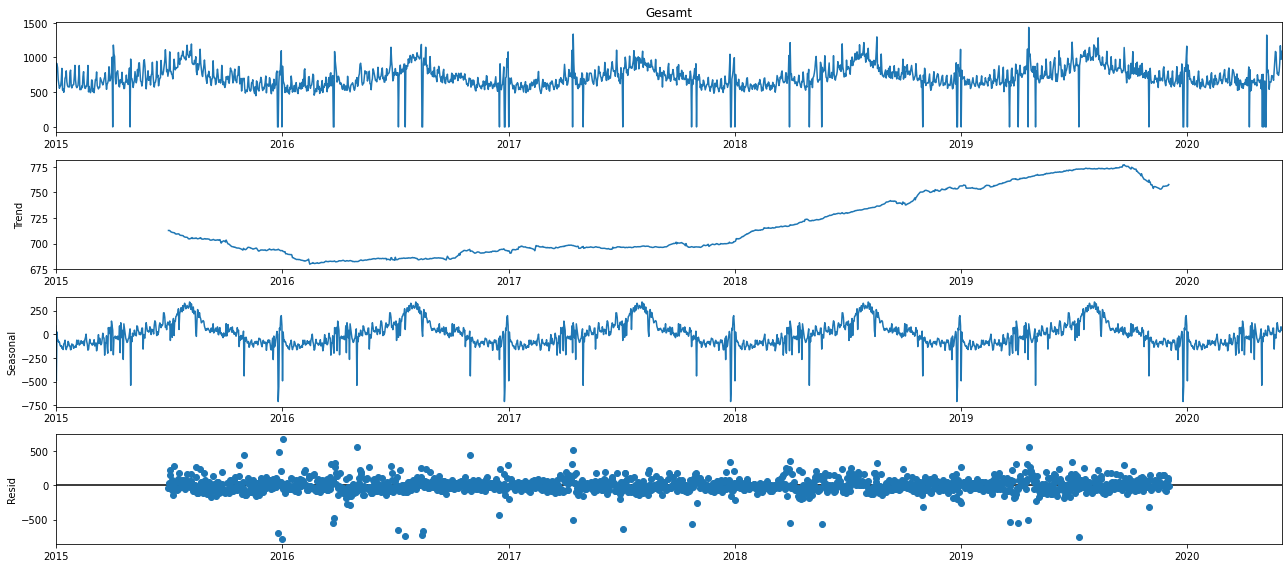

In [356]:
Jahr = 2020
#Decomposition for Filiale 2
y = df_newmodel_2[df_newmodel_2.index.year <= Jahr].Gesamt

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='aditive',period=365)
fig = decomposition.plot()
       
plt.show()

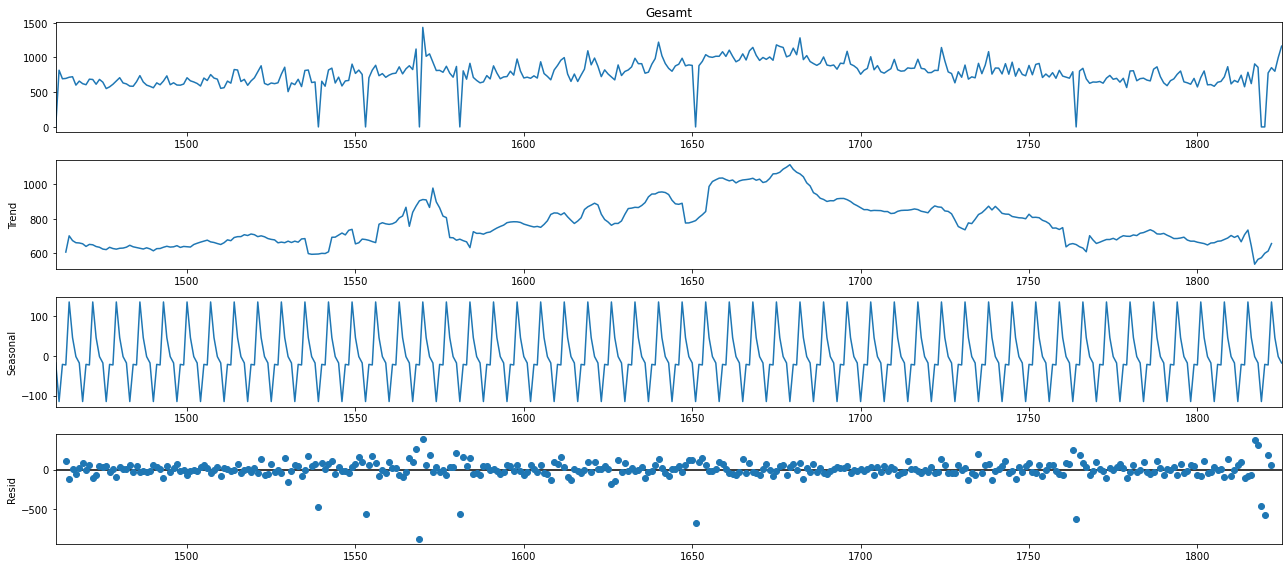

In [357]:
Jahr = 2019
#for idx,fil in enumerate([df_new_1,df_new_2,df_new_3],1):
y = df_new_2[df_newmodel_2.index.year == Jahr].Gesamt
#sum(axis=1)
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='aditive',period=7)
fig = decomposition.plot()
       
plt.show()

### Analysis on Articlegroups

#### Weizenbrot

**Conclusions**
- `The is a longterm trend which can be seen for period=365. The sales volumne decreases over the years.`
-  `There is a weekly and yearly saisonality.`

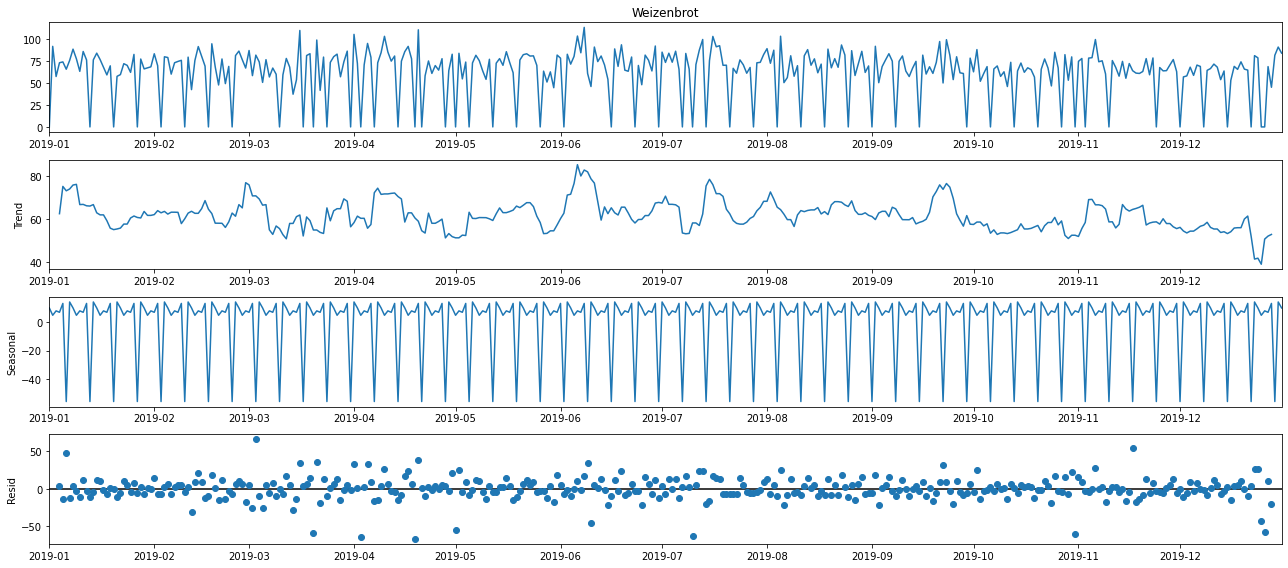

In [358]:
Jahr = 2019
#Decomposition for Filiale 2
y = df_newmodel_2[df_newmodel_2.index.year == Jahr].Weizenbrot

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='aditive',period=7)
fig = decomposition.plot()
       
plt.show()

#### Mischbrot

**Conclusions**
- `The is a longterm trend which can be seen for period=365. The sales volumne increases over the years.`
- `There is a weekly and yearly saisonality.`

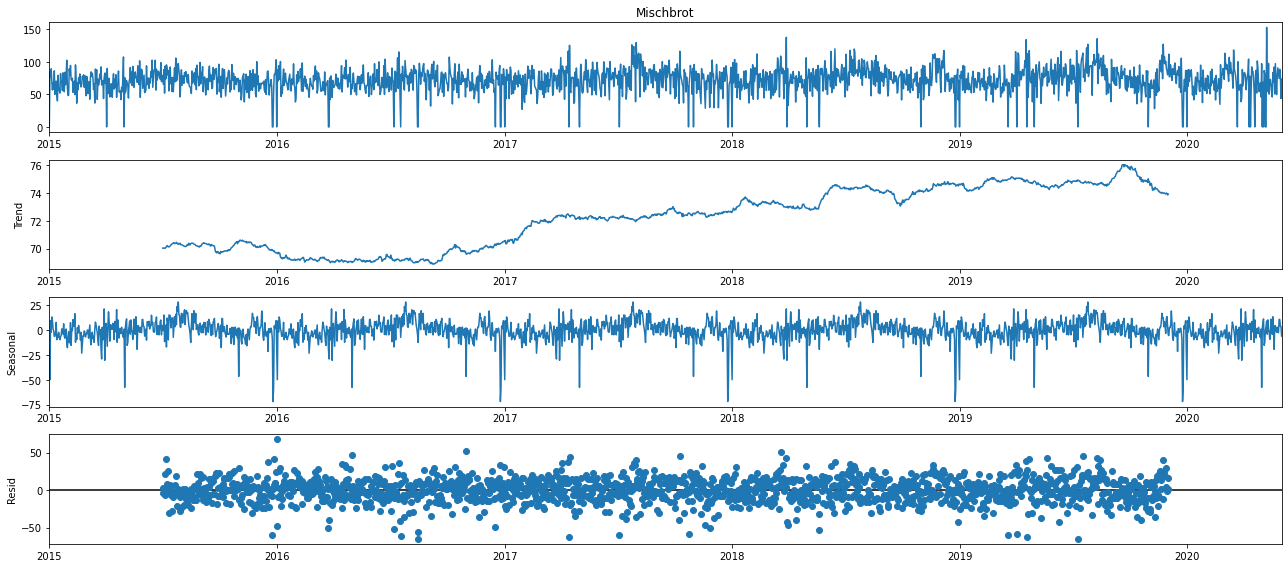

In [359]:
Jahr = 2020
#Decomposition for Filiale 2
y = df_newmodel_2[df_newmodel_2.index.year <= Jahr].Mischbrot

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='aditive',period=365)
fig = decomposition.plot()
       
plt.show()

#### Vollkornbrot

**Conclusions**
- `The is a longterm trend which can be seen for period=365. The sales volumne increases over the years.`
- `There is a weekly saisonality which means period=7.`

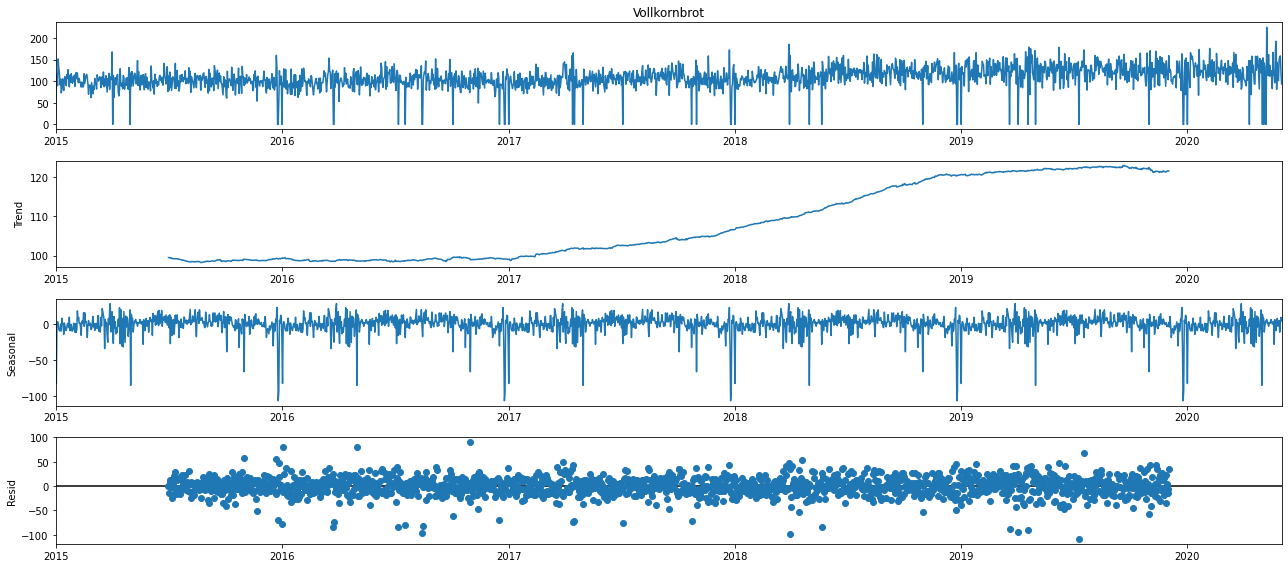

In [360]:
Jahr = 2020
#Decomposition for Filiale 2
y = df_newmodel_2[df_newmodel_2.index.year <= Jahr].Vollkornbrot

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='aditive',period=365)
fig = decomposition.plot()
       
plt.show()

#### Spezialbrot

**Conclusions**
- `After the launch of the product in 2016 the sales volumne is relativly contant over the years.`
- `There is a weekly and yearly saisonality.`

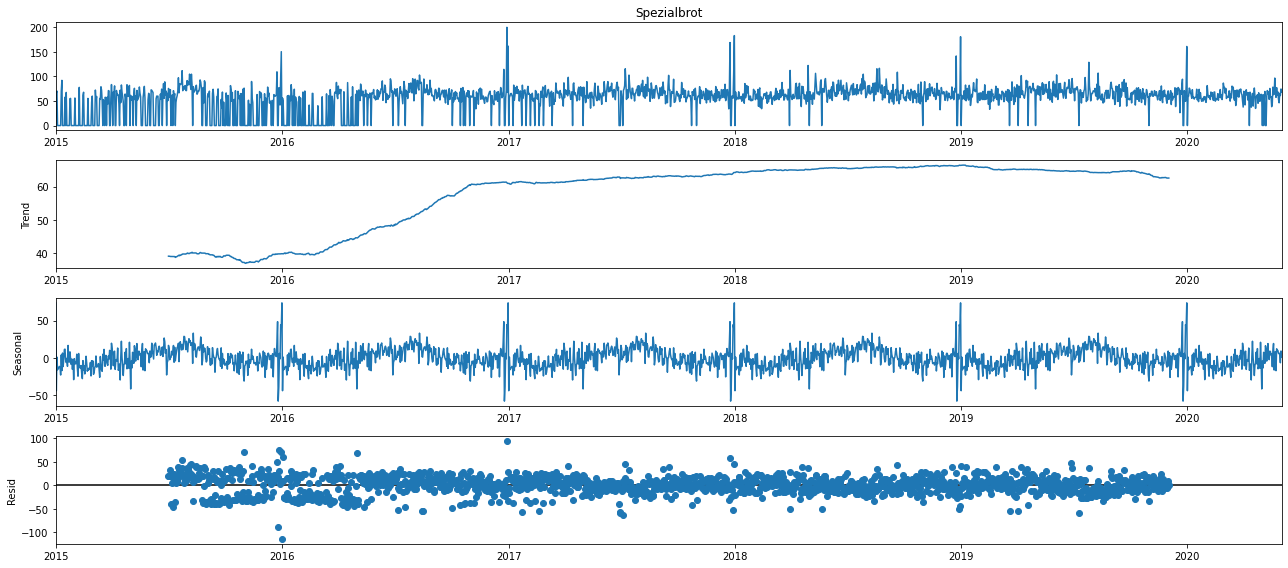

In [361]:
Jahr = 2020
#Decomposition for Filiale 2
y = df_newmodel_2[df_newmodel_2.index.year <= Jahr].Spezialbrot

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='aditive',period=365)
fig = decomposition.plot()
       
plt.show()

#### Stangenbrot

**Conclusions**
- `The is a trend which can be seen for period=365. The sales volumne first increases until 2018 and than increase.`
- `There is a weekly and yearly saisonality.`

In [ ]:
Jahr = 2020
#Decomposition for Filiale 2
y = df_newmodel_2[df_newmodel_2.index.year <= Jahr].Stangenbrote

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='aditive',period=365)
fig = decomposition.plot()
       
plt.show()

#### Brötchen

**Conclusions**
- `The is a longterm trend which can be seen for period=365. The sales volumne increases over the last 3 years.`
- `There is a weekly saisonality which means period=7.`

In [ ]:
Jahr = 2020
#Decomposition for Filiale 2
y = df_newmodel_2[df_newmodel_2.index.year <= Jahr].Brötchen

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='aditive',period=365)
fig = decomposition.plot()
       
plt.show()

#### Süsse Brötchen

**Conclusions**
- `The is a longterm trend which can be seen for period=365. The sales volumne increases over the last 3 years. The plots look very similar to those of previous articlegroup Brötchen.`
- `There are weekly and yearly patterns.`

In [ ]:
Jahr = 2020
#Decomposition for Filiale 2
y = df_newmodel_2[df_newmodel_2.index.year <= Jahr].Süsse_Brötchen

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='aditive',period=7)
fig = decomposition.plot()
       
plt.show()

#### Herzhafte Brötchen

**Conclusions**
- `The is a longterm trend which can be seen for period=365. The sales volumne increases over the last 3 years. The plots look very similar to those of previous articlegroups Brötchen an Süsse_Brötchen.

In [ ]:
Jahr = 2020
#Decomposition for Filiale 2
y = df_newmodel_2[df_newmodel_2.index.year <= Jahr].Herzhafte_Brötchen

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='aditive',period=365)
fig = decomposition.plot()
       
plt.show()

#### KonditoreiBlech

**Conclusions**
- `The is a longterm trend which can be seen for period=365. The sales volumne decreases since 2017. The plots look very similar to those of previous articlegroups Brötchen an Süsse_Brötchen.`
-`There are weekly and yearly patterns within the data.`


In [ ]:
Jahr = 2020
#Decomposition for Filiale 2
y = df_newmodel_2[df_newmodel_2.index.year <= Jahr].KonditoreiBlech

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='aditive',period=365)
fig = decomposition.plot()
       
plt.show()

#### Stückgebäck

**Conclusions**

- `You can see peaks for every New Year's Eve. Inspite of this peaks, the values are rel. constant over the years.`
- `There are weak weekly and yearly patterns within the data.`


In [ ]:
Jahr = 2020
#Decomposition for Filiale 2
y = df_newmodel_2[df_newmodel_2.index.year <= Jahr].Stückgebäck

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='aditive',period=365)
fig = decomposition.plot()
       
plt.show()

#### Blechkuchen

**Conclusions**
- `The is a longterm trend which can be seen for period=365. The sales volumne increases since 2018.`
- `There are weekly and yearly patterns within the data.`


In [ ]:
Jahr = 2020
#Decomposition for Filiale 2
y = df_newmodel_2[df_newmodel_2.index.year <= Jahr].Blechkuchen

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='aditive',period=365)
fig = decomposition.plot()
       
plt.show()

#### Weihnachtsartikel

**Conclusions**
- `The is a longterm trend which can be seen for period=365. The sales volumne increases since 2017.`
- `There are hugh yearly patterns within the data, which does not surprise.`


In [ ]:
Jahr = 2020
#Decomposition for Filiale 2
y = df_newmodel_2[df_newmodel_2.index.year <= Jahr].Weihnachtsartikel

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='aditive',period=365)
fig = decomposition.plot()
       
plt.show()

## Lag Plots

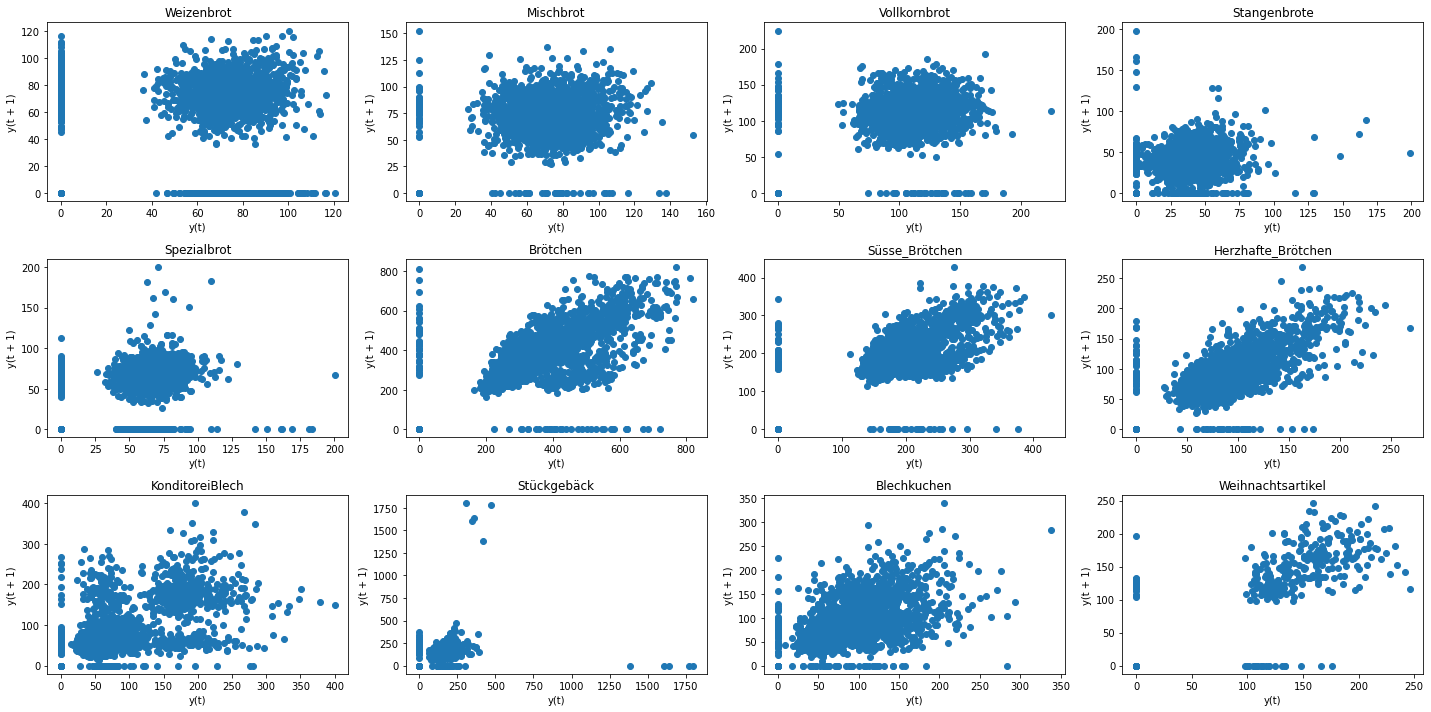

In [90]:
# Make the graph 20 inches by 10 inches
plt.figure(figsize=(20,10), facecolor='white')

# plot numbering starts at 1, not 0
plot_number = 1
for name in df_basis_2.columns:

    ax = plt.subplot(3, 4, plot_number)
    lag_plot(df_basis_2['%s' % (name)],ax=ax)
    ax.set_title(name)
    # Go to the next plot for the next loop
    plot_number = plot_number + 1
plt.tight_layout()

## Autocorrelation Plots

### for Filiale 2

In [93]:

y_2_gesamt=df_newmodel_2.Gesamt[:'15.03.2020']


**Conclusions**
- `From the plot you can see there is a high peak in correlation at the lag of 7th day, then again on the 14th day
and so on. The series is perfectly autocorrelated with a lag of 1 week.`
- `This is valid for all single articlegroups with the exception Weihnachtsartikel. See single plots.`
- `For all articlegroups except Brot(Vollkornbrot, Weizenbrot,..) you see a  peak in correlation at the lag of 365th day.`


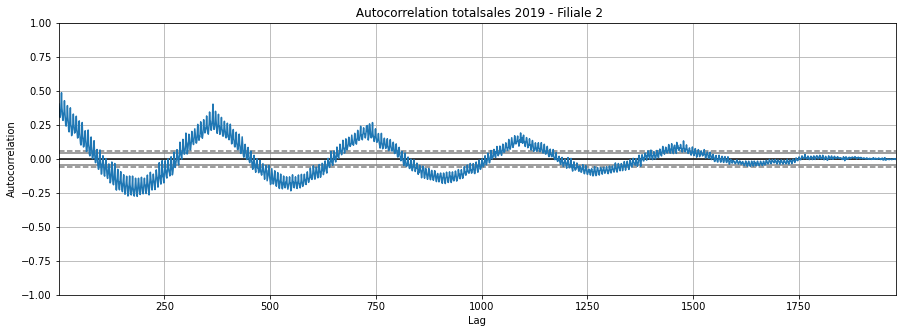

In [94]:
# Autocorrelation totalsales  - Filiale 2
from pandas.plotting import autocorrelation_plot
plt.figure(figsize=(15,5))
autocorrelation_plot(df_new_2.Gesamt).set_title(" Autocorrelation totalsales 2019 - Filiale 2")
plt.show()

In [95]:
#fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,5))
#fig.suptitle('AC and PAC for Filiale 2')
#sm.graphics.tsa.plot_acf(df_new_2.Gesamt.squeeze(), lags=20, ax=ax1)
#sm.graphics.tsa.plot_pacf(df_new_2.Gesamt.squeeze(), lags=20, ax=ax2)
#plt.show()


### For Filiale 2 on Articlegroups

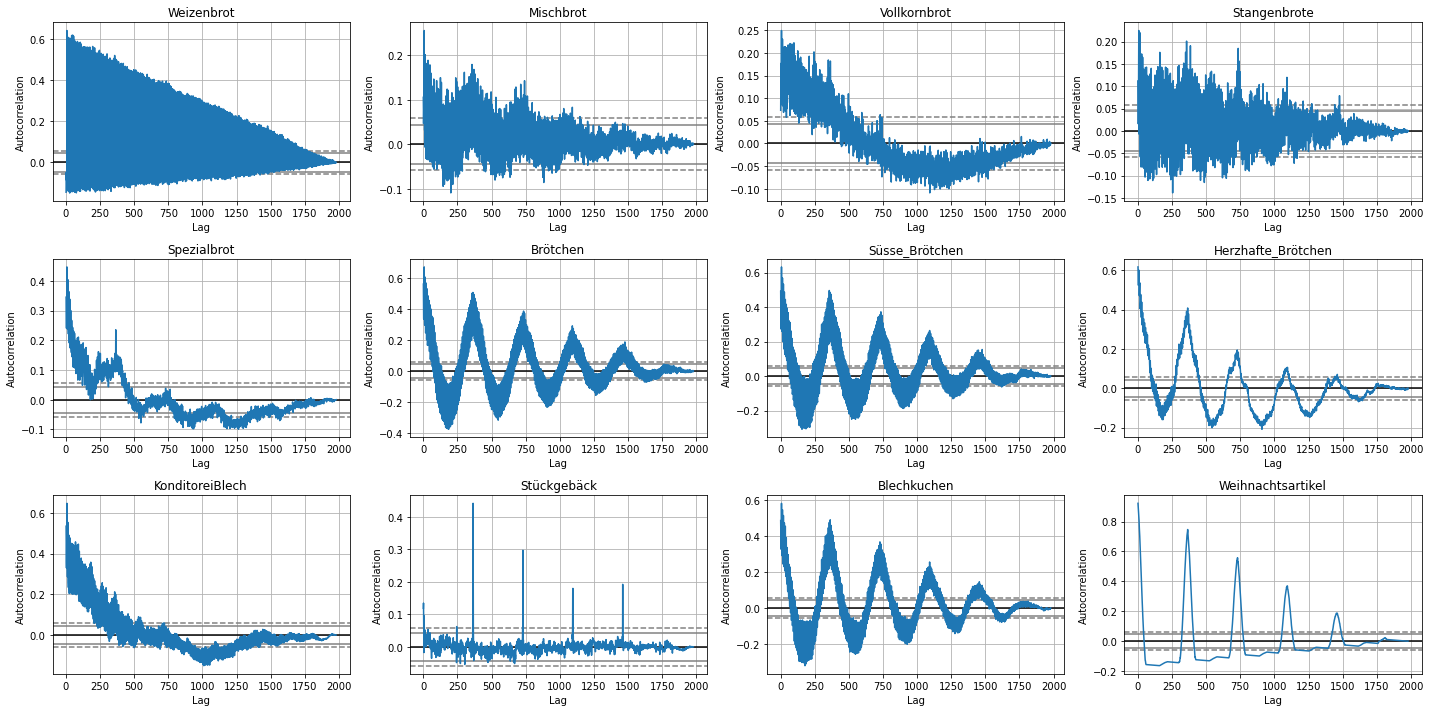

In [96]:
# Analyse weekly dependencies
plt.figure(figsize=(20,10), facecolor='white')

# plot numbering starts at 1, not 0
plot_number = 1
for name in df_basis_2.columns:

    ax = plt.subplot(3, 4, plot_number)
    autocorrelation_plot(df_basis_2['%s' % (name)],ax=ax)
    ax.set_title(name)
    # Go to the next plot for the next loop
    plot_number = plot_number + 1
plt.tight_layout()

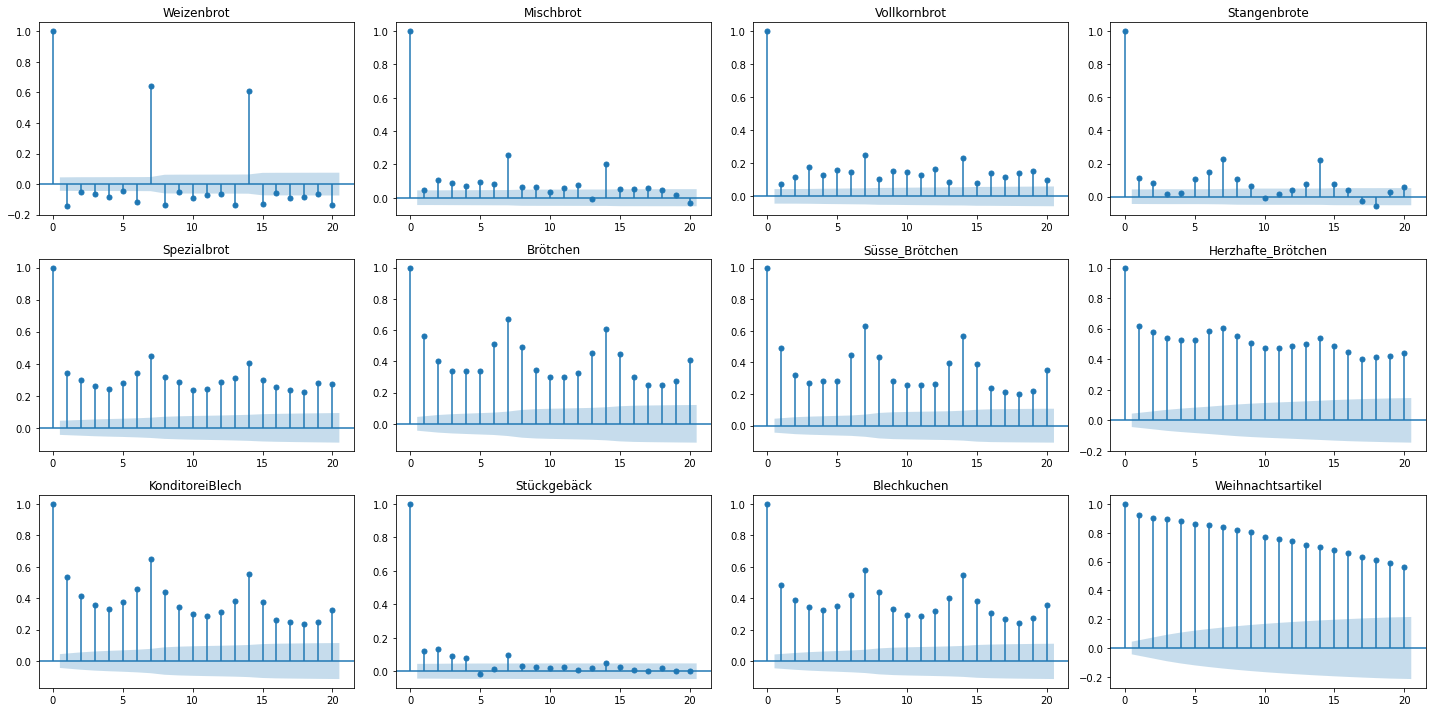

In [97]:
# Analyse weekly dependencies - ACF
plt.figure(figsize=(20,10), facecolor='white')

# plot numbering starts at 1, not 0
plot_number = 1
for name in df_basis_2.columns:

    ax = plt.subplot(3, 4, plot_number)
    plot_acf(df_basis_2['%s' % (name)],lags=20,ax=ax)
    ax.set_title(name)
    # Go to the next plot for the next loop
    plot_number = plot_number + 1
plt.tight_layout()

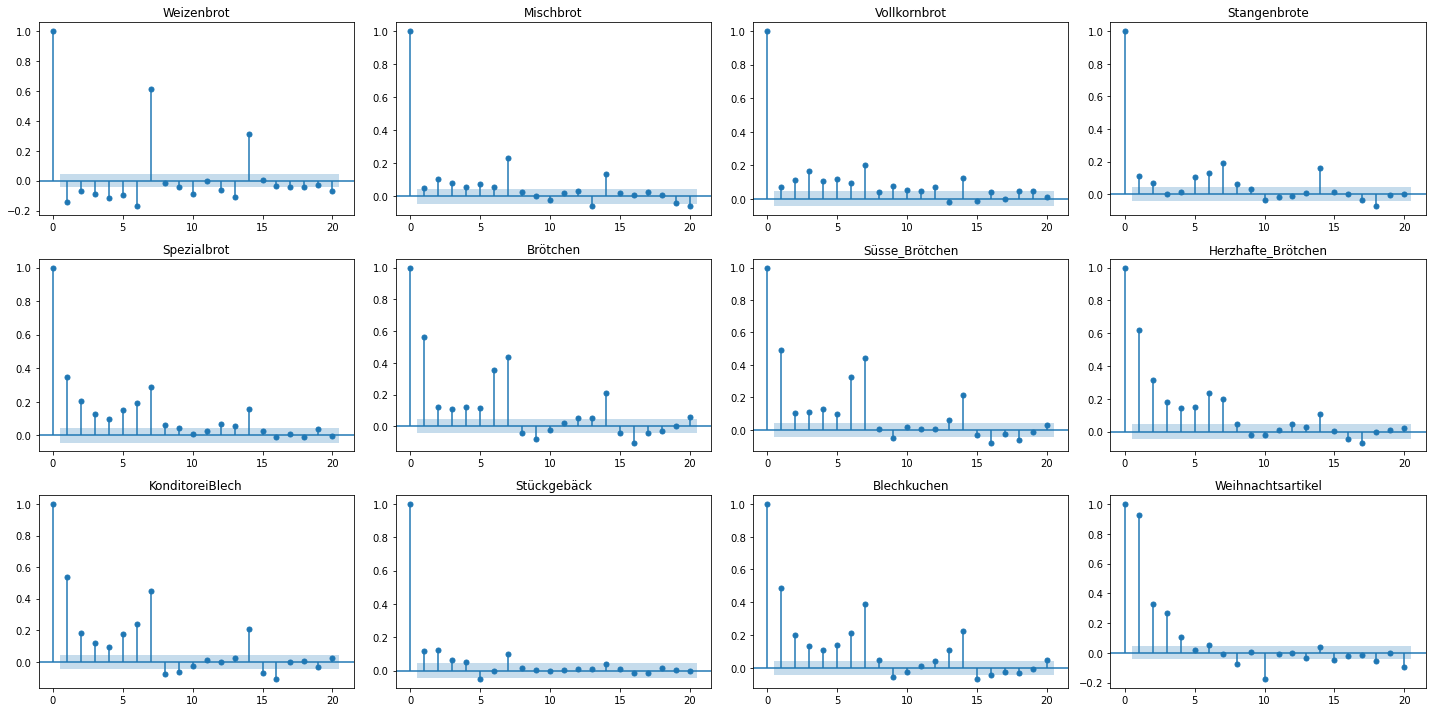

In [98]:
# Analyse weekly dependencies - PACF
plt.figure(figsize=(20,10), facecolor='white')

# plot numbering starts at 1, not 0
plot_number = 1
for name in df_basis_2.columns:

    ax = plt.subplot(3, 4, plot_number)
    plot_pacf(df_basis_2['%s' % (name)],lags=20,ax=ax)
    ax.set_title(name)
    # Go to the next plot for the next loop
    plot_number = plot_number + 1
plt.tight_layout()

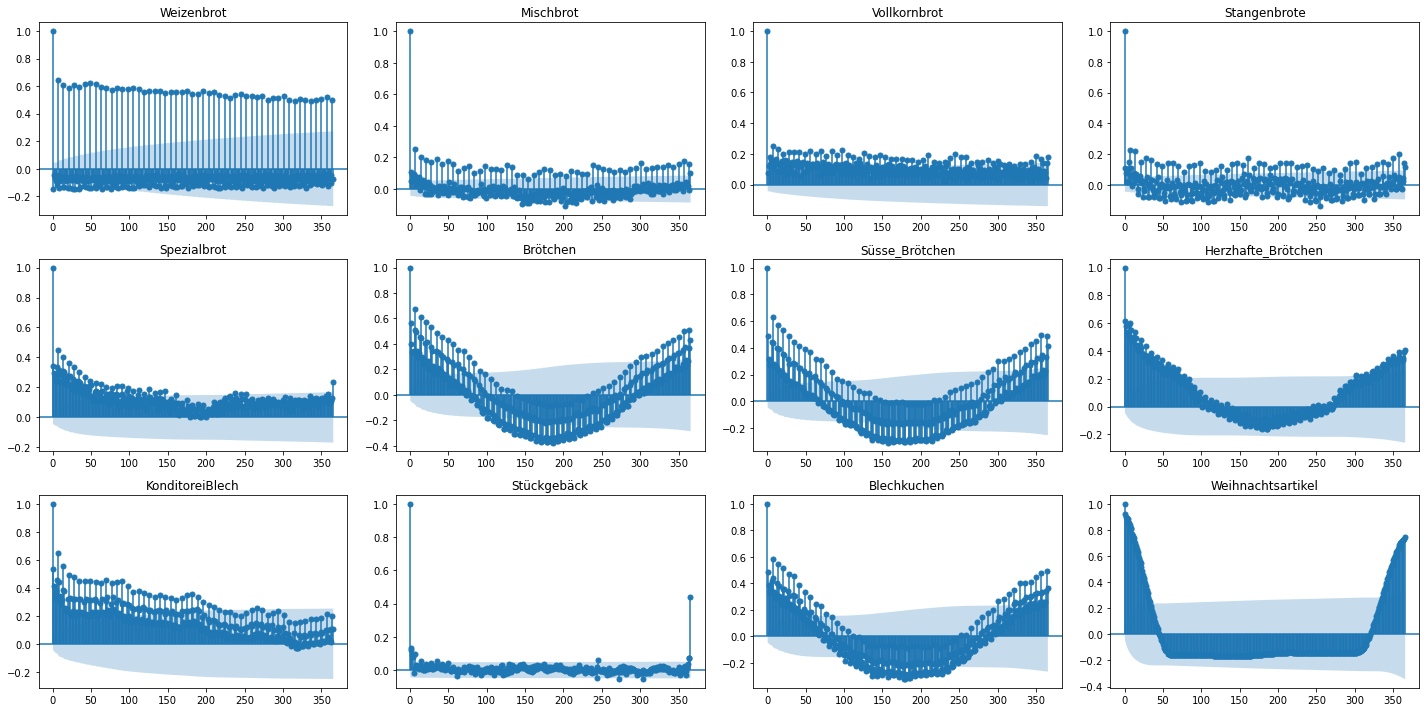

In [99]:
# Analyse yearly dependencies - ACF
plt.figure(figsize=(20,10), facecolor='white')

# plot numbering starts at 1, not 0
plot_number = 1
for name in df_basis_2.columns:

    ax = plt.subplot(3, 4, plot_number)
    plot_acf(df_basis_2['%s' % (name)],lags=365,ax=ax)
    ax.set_title(name)
    # Go to the next plot for the next loop
    plot_number = plot_number + 1
plt.tight_layout()

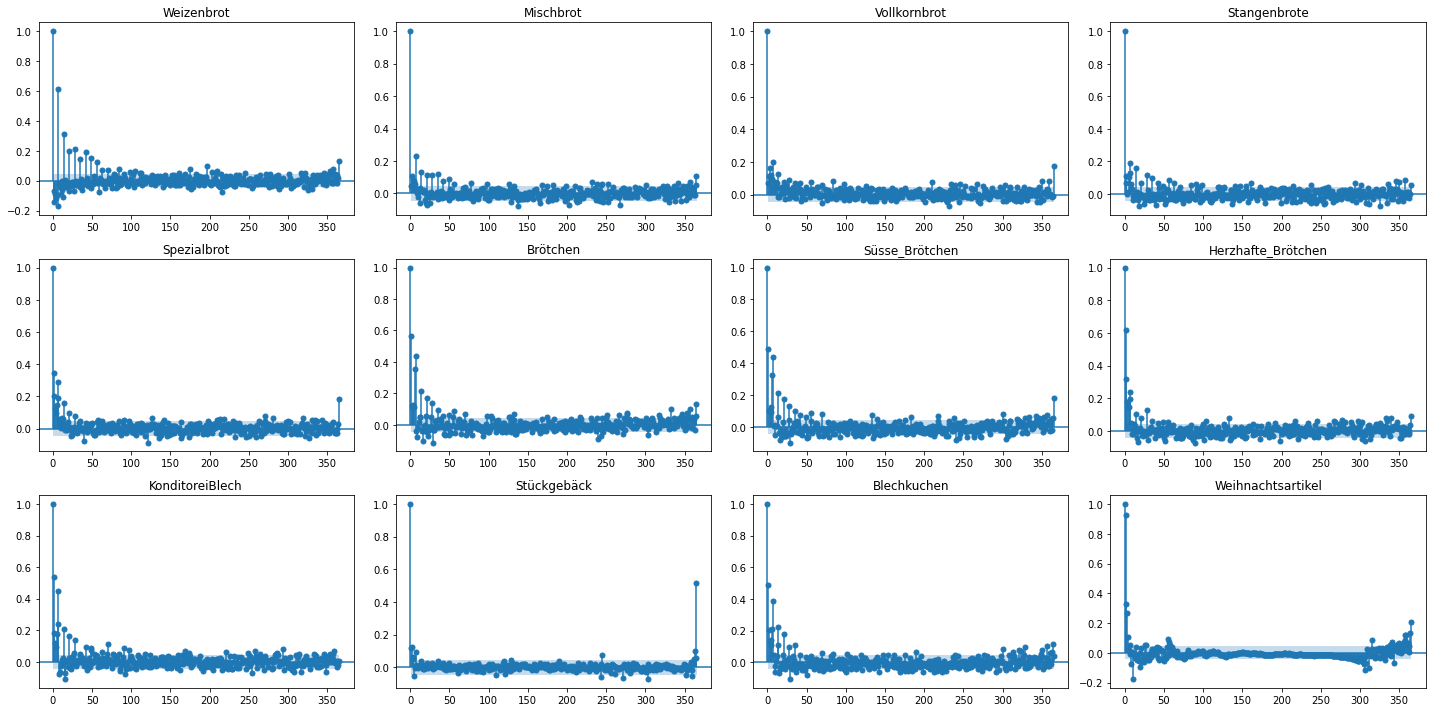

In [100]:
# Analyse yearly dependencies - PACF
plt.figure(figsize=(20,10), facecolor='white')

# plot numbering starts at 1, not 0
plot_number = 1
for name in df_basis_2.columns:

    ax = plt.subplot(3, 4, plot_number)
    plot_pacf(df_basis_2['%s' % (name)],lags=365,ax=ax)
    ax.set_title(name)
    # Go to the next plot for the next loop
    plot_number = plot_number + 1
plt.tight_layout()

## Check Stationarity

**Conclusions**
- `The couple of series are not stationary. To use VARIMA/VARIMAX  all of the Series needs to be stationary.`
- `After 1 time differentiation all of  the series are difference-stationary / Typ I(1).`

In [112]:
#df_basis_2_cut

In [101]:
#Apply Check to timeseries of Filiale 1
for name in df_basis_2.columns:
    adf_test_long(df_basis_2[name])
    

Ergebnis für Timeseries Vollkornbrot:
Test Statistic            -2.300552
p-value                    0.171790
# Lags                    42.000000
# Observations          1936.000000
Critical Value (1%)       -3.433732
Critical Value (5%)       -2.863034
Critical Value (10%)      -2.567565
dtype: float64
 Series is Non-Stationary
Ergebnis für Timeseries KonditoreiBlech:
Test Statistic            -1.496015
p-value                    0.535482
# Lags                    98.000000
# Observations          1880.000000
Critical Value (1%)       -3.433833
Critical Value (5%)       -2.863079
Critical Value (10%)      -2.567589
dtype: float64
 Series is Non-Stationary
Ergebnis für Timeseries Stückgebäck:
Test Statistic            -1.922365
p-value                    0.321614
# Lags                   365.000000
# Observations          1613.000000
Critical Value (1%)       -3.434411
Critical Value (5%)       -2.863334
Critical Value (10%)      -2.567725
dtype: float64
 Series is Non-Stationary
Ergeb

In [102]:
#Apply Check to timeseries of Filiale 2
for name in df_basis_2.columns:
    adf_test(df_basis_2[name])
    

 Ergebnis für Timeseries Weizenbrot: Series is Stationary
 Ergebnis für Timeseries Mischbrot: Series is Stationary
Ergebnis für Timeseries Vollkornbrot: Series is Non-Stationary
 Ergebnis für Timeseries Stangenbrote: Series is Stationary
 Ergebnis für Timeseries Spezialbrot: Series is Stationary
 Ergebnis für Timeseries Brötchen: Series is Stationary
 Ergebnis für Timeseries Süsse_Brötchen: Series is Stationary
 Ergebnis für Timeseries Herzhafte_Brötchen: Series is Stationary
Ergebnis für Timeseries KonditoreiBlech: Series is Non-Stationary
Ergebnis für Timeseries Stückgebäck: Series is Non-Stationary
 Ergebnis für Timeseries Blechkuchen: Series is Stationary
Ergebnis für Timeseries Weihnachtsartikel: Series is Non-Stationary


In [121]:
for name in df_basis_2_cut.columns:
    adf_test(df_basis_2_cut[name])

 Ergebnis für Timeseries Weizenbrot: Series is Stationary
 Ergebnis für Timeseries Mischbrot: Series is Stationary
Ergebnis für Timeseries Vollkornbrot: Series is Non-Stationary
 Ergebnis für Timeseries Stangenbrote: Series is Stationary
 Ergebnis für Timeseries Spezialbrot: Series is Stationary
 Ergebnis für Timeseries Brötchen: Series is Stationary
 Ergebnis für Timeseries Süsse_Brötchen: Series is Stationary
 Ergebnis für Timeseries Herzhafte_Brötchen: Series is Stationary
Ergebnis für Timeseries KonditoreiBlech: Series is Non-Stationary
Ergebnis für Timeseries Stückgebäck: Series is Non-Stationary
 Ergebnis für Timeseries Blechkuchen: Series is Stationary
Ergebnis für Timeseries Weihnachtsartikel: Series is Non-Stationary


In [113]:
for name in df_basis_2.columns:
    adf_test(df_basis_2[name].diff().dropna())

 Ergebnis für Timeseries Weizenbrot: Series is Stationary
 Ergebnis für Timeseries Mischbrot: Series is Stationary
 Ergebnis für Timeseries Vollkornbrot: Series is Stationary
 Ergebnis für Timeseries Stangenbrote: Series is Stationary
 Ergebnis für Timeseries Spezialbrot: Series is Stationary
 Ergebnis für Timeseries Brötchen: Series is Stationary
 Ergebnis für Timeseries Süsse_Brötchen: Series is Stationary
 Ergebnis für Timeseries Herzhafte_Brötchen: Series is Stationary
 Ergebnis für Timeseries KonditoreiBlech: Series is Stationary
 Ergebnis für Timeseries Stückgebäck: Series is Stationary
 Ergebnis für Timeseries Blechkuchen: Series is Stationary
 Ergebnis für Timeseries Weihnachtsartikel: Series is Stationary


## Check Causality

**Conclusions**
- `Looking at the p-Values we can assume that almost all variables are interchangeably each user.`
- `A exception is the articlegroup Blechkuchen.`
- `Overall this justifies an multivariate approach for prediction.`

In [ ]:
maxlag=12
test = 'ssr-chi2test'

def grangers_causality_matrix(X_train, variables,Filiale, test = 'ssr_chi2test', verbose=False):
   dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
   for c in dataset.columns:
    for r in dataset.index:
        test_result = grangercausalitytests(X_train[[r,c]], maxlag=maxlag, verbose=False)
        p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
        if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
        min_p_value = np.min(p_values)
        dataset.loc[r,c] = min_p_value
        
    dataset.columns = [var + '_x_'+ Filiale for var in variables]
    dataset.index = [var + '_y' for var in variables]

    return dataset


In [116]:
df_basisnew_2=df_newmodel_2.iloc[:,0:12]

In [117]:
result_2=grangers_causality_matrix(df_basisnew_2, df_basisnew_2.columns,Filiale='Filiale_2')


## Cointegrationtest

In [118]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

### Filiale 2

In [120]:
cointegration_test(df_basisnew_2)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Weizenbrot ::  1844.45   > 311.1288  =>   True
Mischbrot ::  1260.31   > 263.2603  =>   True
Vollkornbrot ::  971.21    > 219.4051  =>   True
Stangenbrote ::  744.93    > 179.5199  =>   True
Spezialbrot ::  569.33    > 143.6691  =>   True
Brötchen ::  405.24    > 111.7797  =>   True
Süsse_Brötchen ::  268.81    > 83.9383   =>   True
Herzhafte_Brötchen ::  174.84    > 60.0627   =>   True
KonditoreiBlech ::  86.02     > 40.1749   =>   True
Stückgebäck ::  43.49     > 24.2761   =>   True
Blechkuchen ::  19.22     > 12.3212   =>   True
Weihnachtsartikel ::  0.96      > 4.1296    =>   False


# Checks Timeseries Filiale 3

## Decompose weekly, monthly and yearly effects as well as trends

In [124]:
df_newmodel_3 = df_new_3.copy().set_index('Datum')

### Exploration for Filiale 3

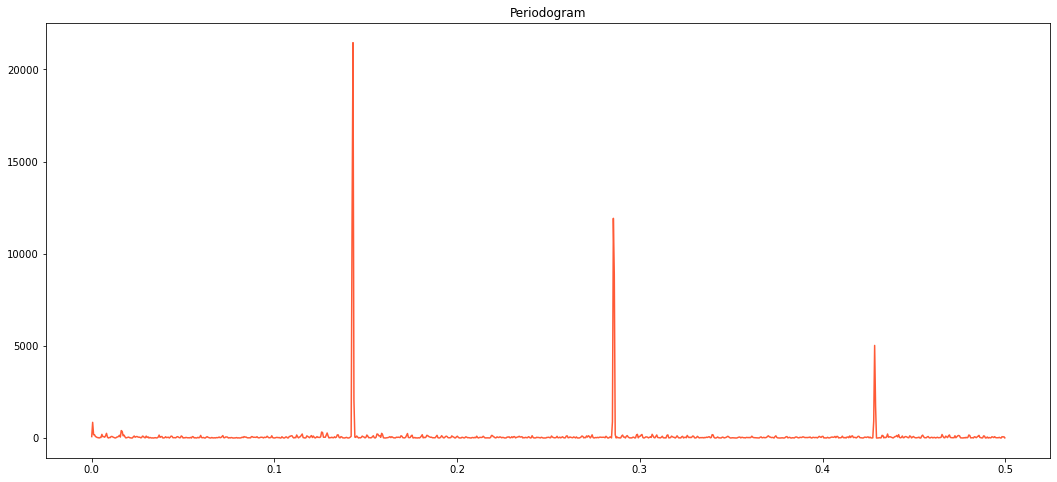

In [125]:
# We use for the sampling frequency 1 as we want to
# discover cycles over the original time steps.
f, Pxx = signal.periodogram(df_newmodel_3.Gesamt, fs = 1, window='hanning', scaling='spectrum')
plt.plot(f, Pxx, color = NF_ORANGE)
plt.title('Periodogram')
plt.show()

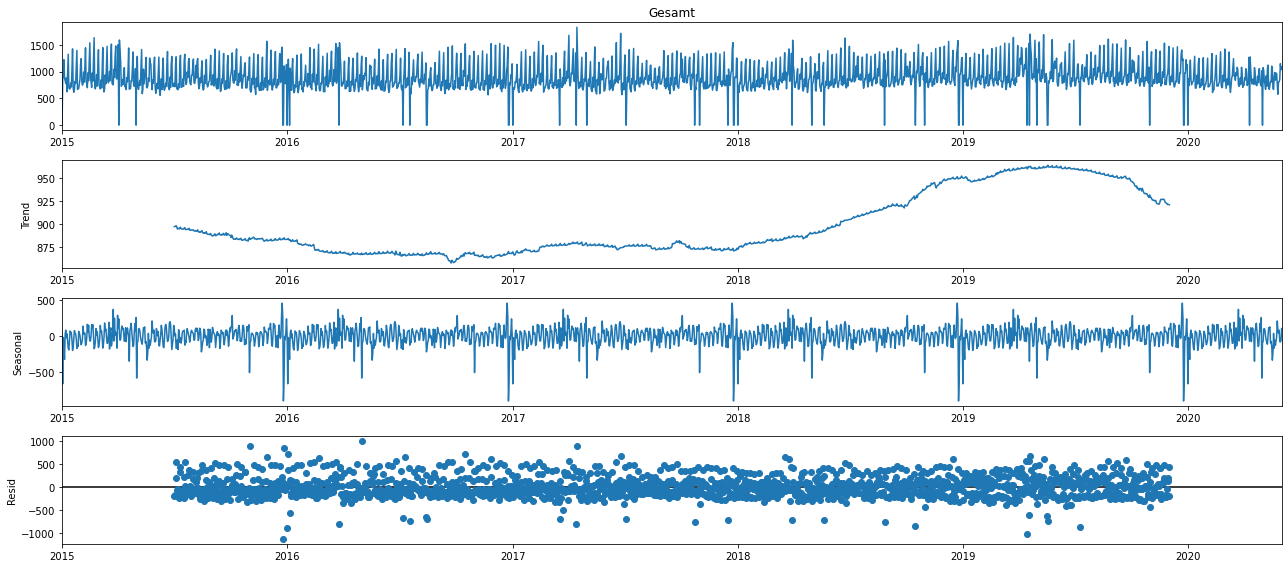

In [126]:
Jahr = 2020
#Decomposition for Filiale 3
y = df_newmodel_3[df_newmodel_3.index.year <= Jahr].Gesamt

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='aditive',period=365)
fig = decomposition.plot()
       
plt.show()

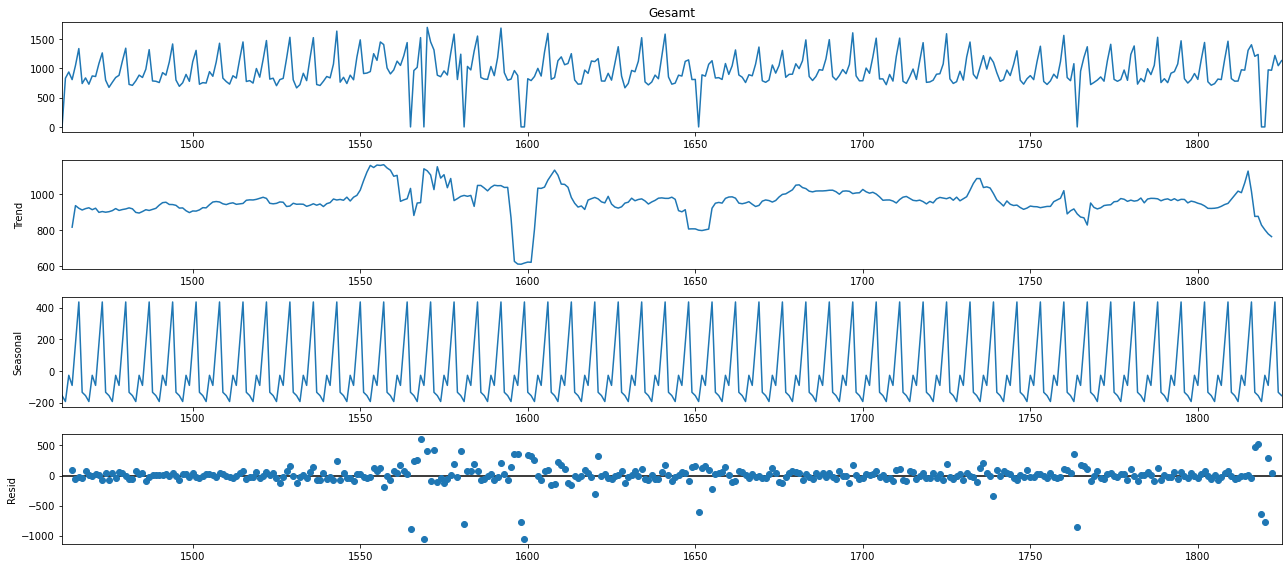

In [127]:
Jahr = 2019
#for idx,fil in enumerate([df_new_1,df_new_2,df_new_3],1):
y = df_new_3[df_newmodel_3.index.year == Jahr].Gesamt
#sum(axis=1)
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='aditive',period=7)
fig = decomposition.plot()
       
plt.show()

### Analysis on Articlegroups

#### Weizenbrot

**Conclusions**
- `The is a longterm trend which can be seen for period=365. The sales volumne decreases over the years.`
-  `There is a weekly and yearly saisonality.`

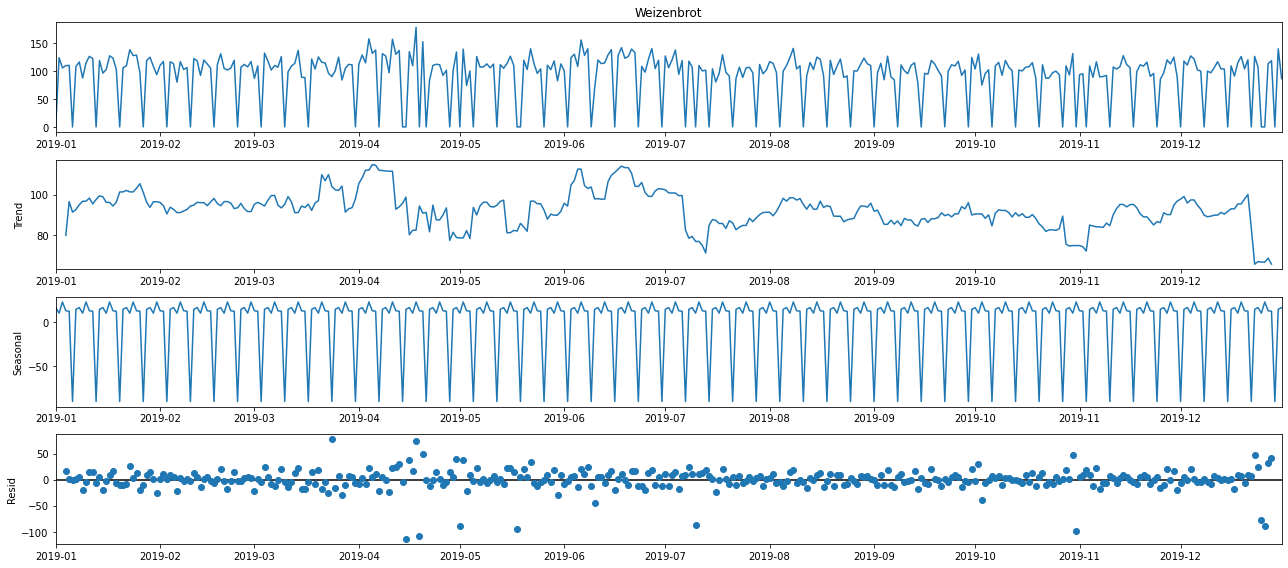

In [128]:
Jahr = 2019
#Decomposition for Filiale 3
y = df_newmodel_3[df_newmodel_3.index.year == Jahr].Weizenbrot

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='aditive',period=7)
fig = decomposition.plot()
       
plt.show()

#### Mischbrot

**Conclusions**
- `The is a longterm trend which can be seen for period=365. The sales volumne increases over the years.`
- `There is a weekly and yearly saisonality.`

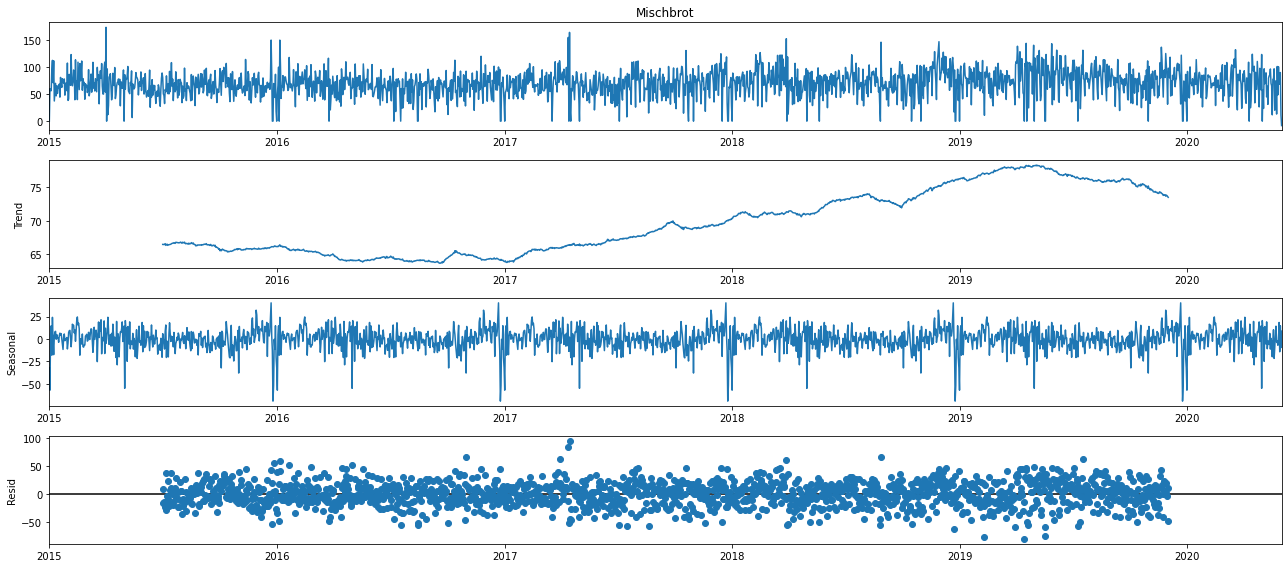

In [129]:
Jahr = 2020
#Decomposition for Filiale 3
y = df_newmodel_3[df_newmodel_3.index.year <= Jahr].Mischbrot

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='aditive',period=365)
fig = decomposition.plot()
       
plt.show()

#### Vollkornbrot

**Conclusions**
- `The is a longterm trend which can be seen for period=365. The sales volumne increases over the years.`
- `There is a weekly saisonality which means period=7.`

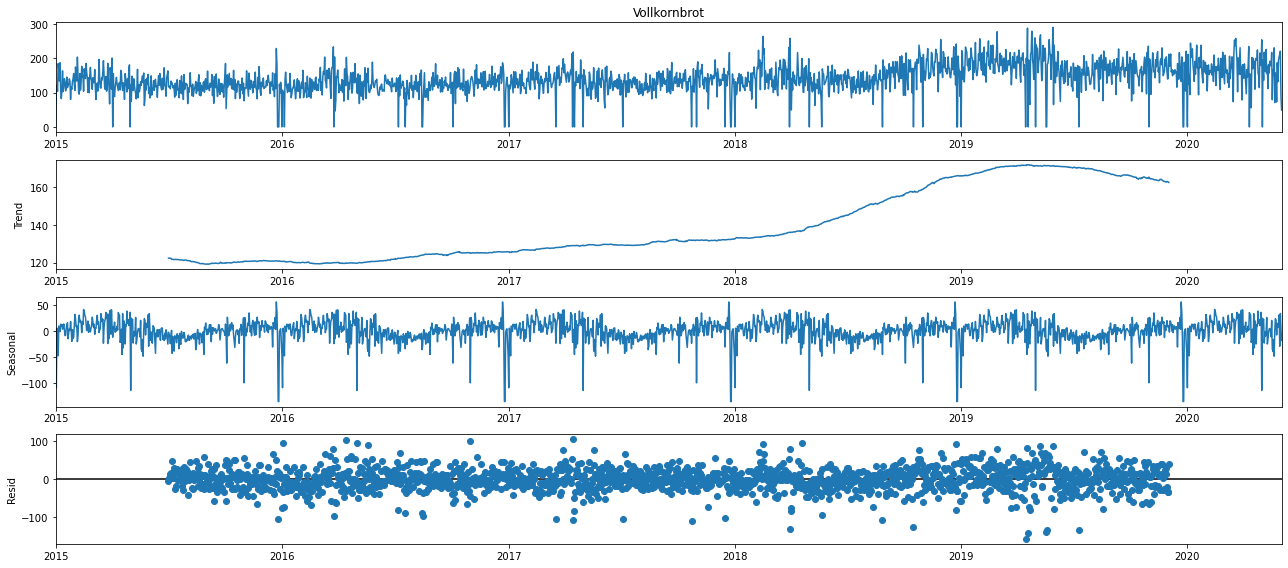

In [130]:
Jahr = 2020
#Decomposition for Filiale 3
y = df_newmodel_3[df_newmodel_3.index.year <= Jahr].Vollkornbrot

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='aditive',period=365)
fig = decomposition.plot()
       
plt.show()

#### Spezialbrot

**Conclusions**
- `After the launch of the product in 2016 the sales volumne is relativly contant over the years.`
- `There is a weekly and yearly saisonality.`

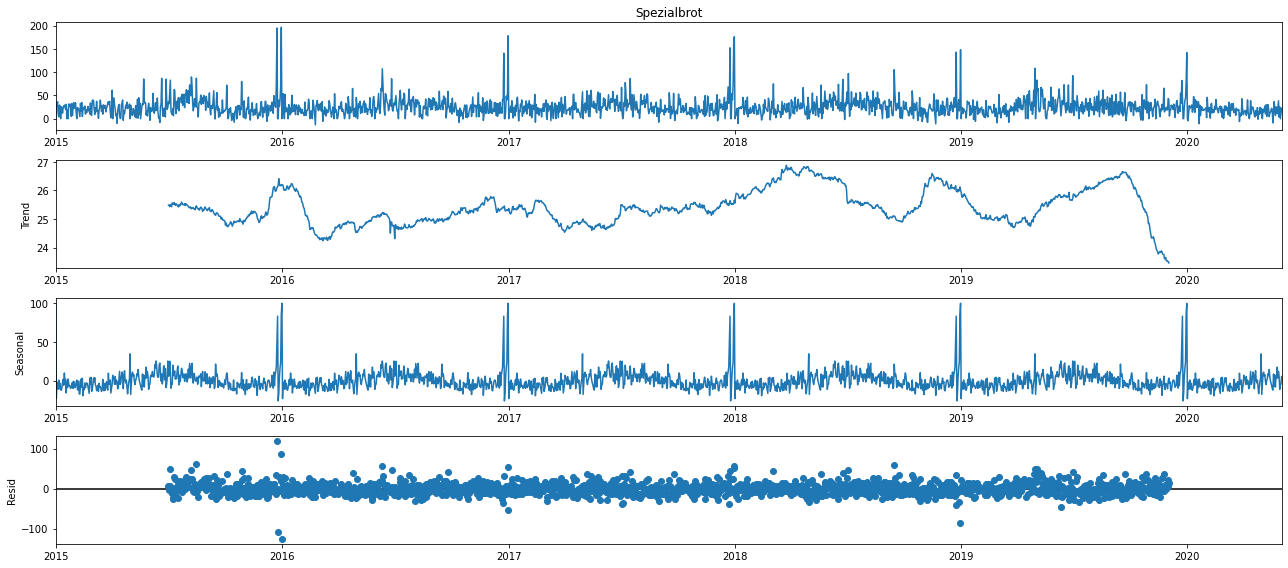

In [131]:
Jahr = 2020
#Decomposition for Filiale 3
y = df_newmodel_3[df_newmodel_3.index.year <= Jahr].Spezialbrot

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='aditive',period=365)
fig = decomposition.plot()
       
plt.show()

#### Stangenbrot

**Conclusions**
- `The is a trend which can be seen for period=365. The sales volumne first increases until 2018 and than increase.`
- `There is a weekly and yearly saisonality.`

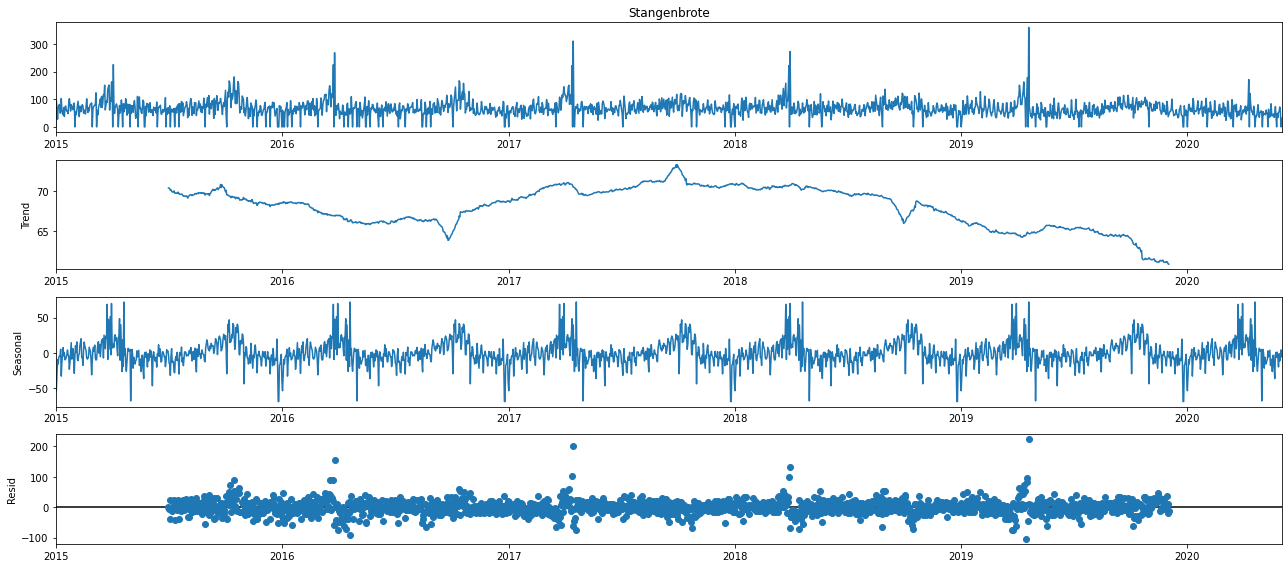

In [132]:
Jahr = 2020
#Decomposition for Filiale 3
y = df_newmodel_3[df_newmodel_3.index.year <= Jahr].Stangenbrote

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='aditive',period=365)
fig = decomposition.plot()
       
plt.show()

#### Brötchen

**Conclusions**
- `The is a longterm trend which can be seen for period=365. The sales volumne increases over the last 3 years.`
- `There is a weekly saisonality which means period=7.`

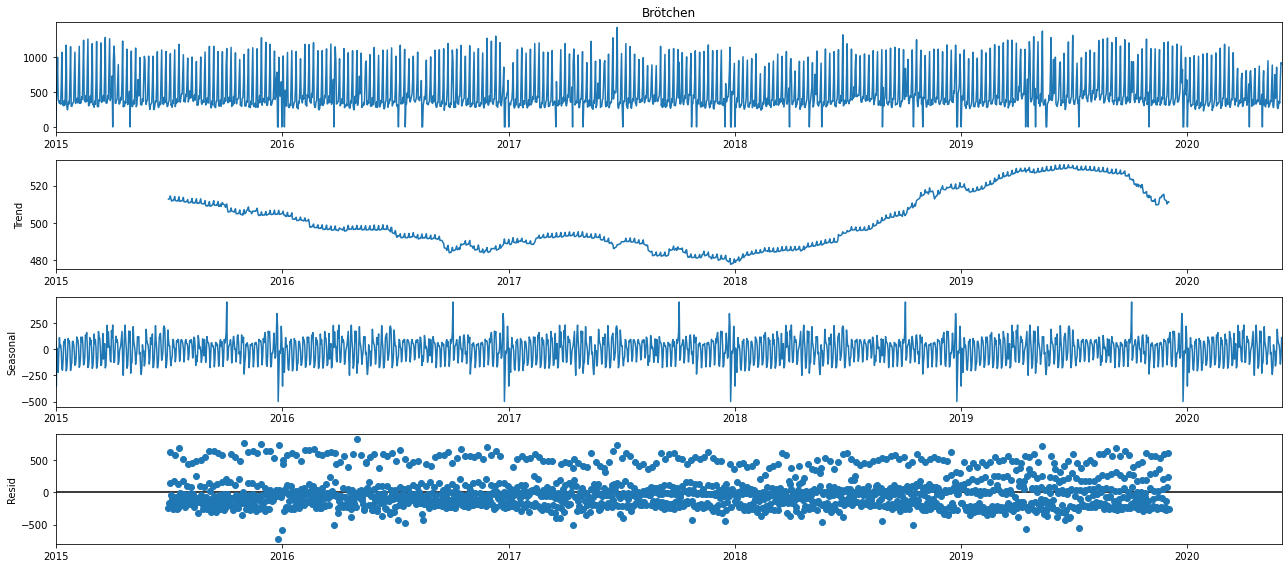

In [133]:
Jahr = 2020
#Decomposition for Filiale 2
y = df_newmodel_3[df_newmodel_3.index.year <= Jahr].Brötchen

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='aditive',period=365)
fig = decomposition.plot()
       
plt.show()

#### Süsse Brötchen

**Conclusions**
- `The is a longterm trend which can be seen for period=365. The sales volumne increases over the last 3 years. The plots look very similar to those of previous articlegroup Brötchen.`
- `There are weekly and yearly patterns.`

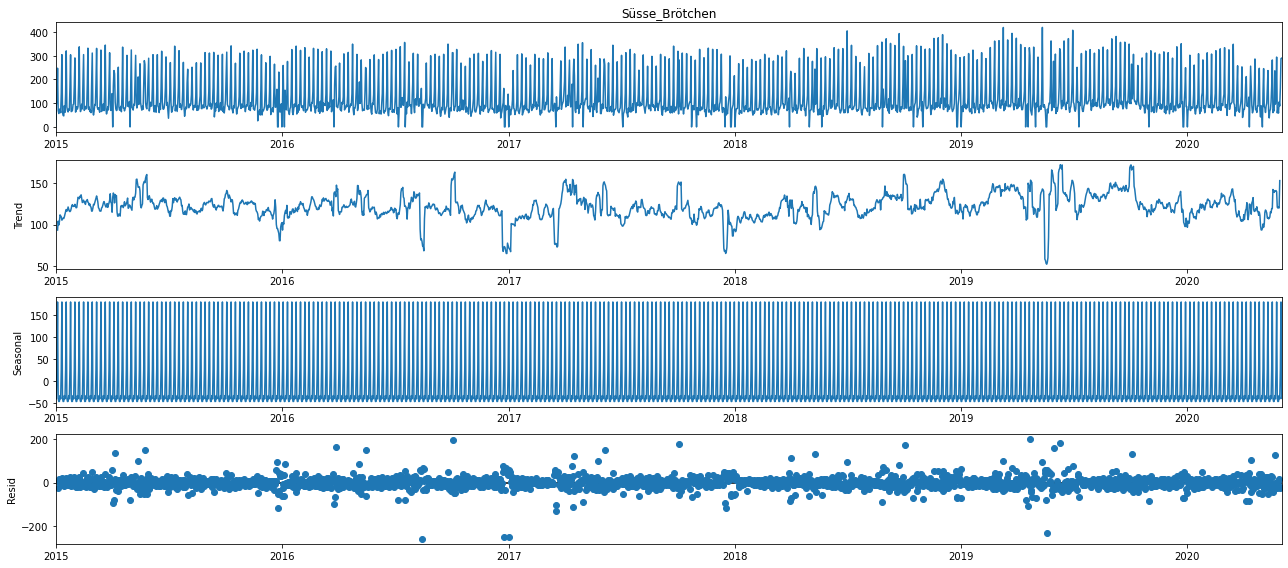

In [134]:
Jahr = 2020
#Decomposition for Filiale 2
y = df_newmodel_3[df_newmodel_3.index.year <= Jahr].Süsse_Brötchen

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='aditive',period=7)
fig = decomposition.plot()
       
plt.show()

#### Herzhafte Brötchen

**Conclusions**
- `The is a longterm trend which can be seen for period=365. The sales volumne increases over the last 3 years. The plots look very similar to those of previous articlegroups Brötchen an Süsse_Brötchen.`


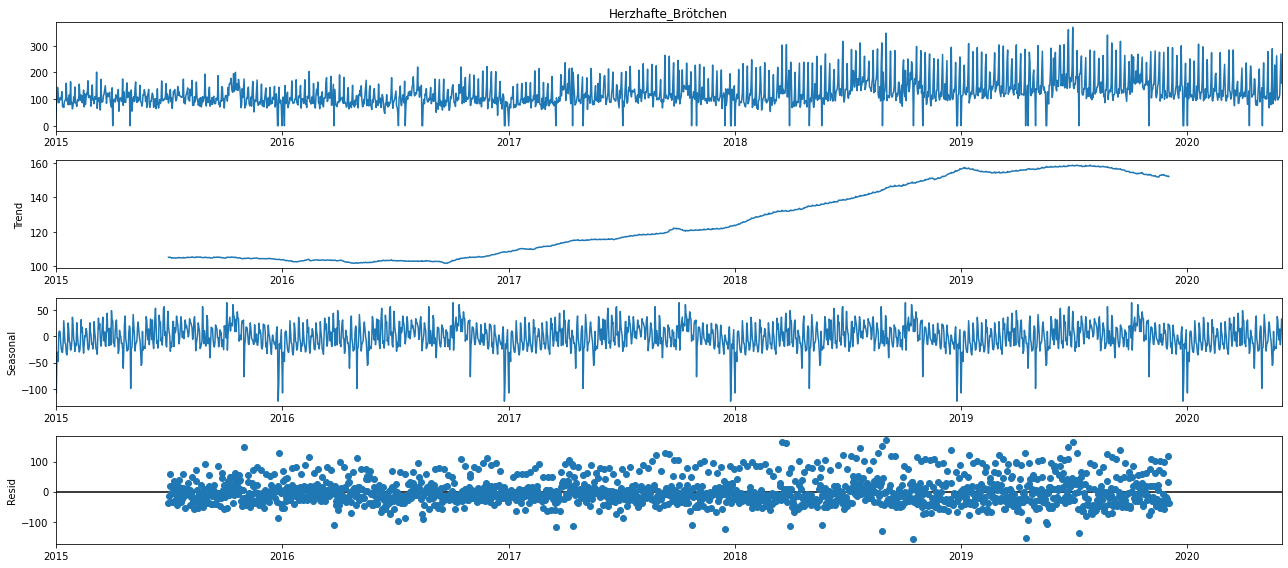

In [135]:
Jahr = 2020
#Decomposition for Filiale 3
y = df_newmodel_3[df_newmodel_3.index.year <= Jahr].Herzhafte_Brötchen

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='aditive',period=365)
fig = decomposition.plot()
       
plt.show()

#### KonditoreiBlech

**Conclusions**
- `The is a longterm trend which can be seen for period=365. The sales volumne decreases since 2017. The plots look very similar to those of previous articlegroups Brötchen an Süsse_Brötchen.`
-`There are weekly and yearly patterns within the data.`


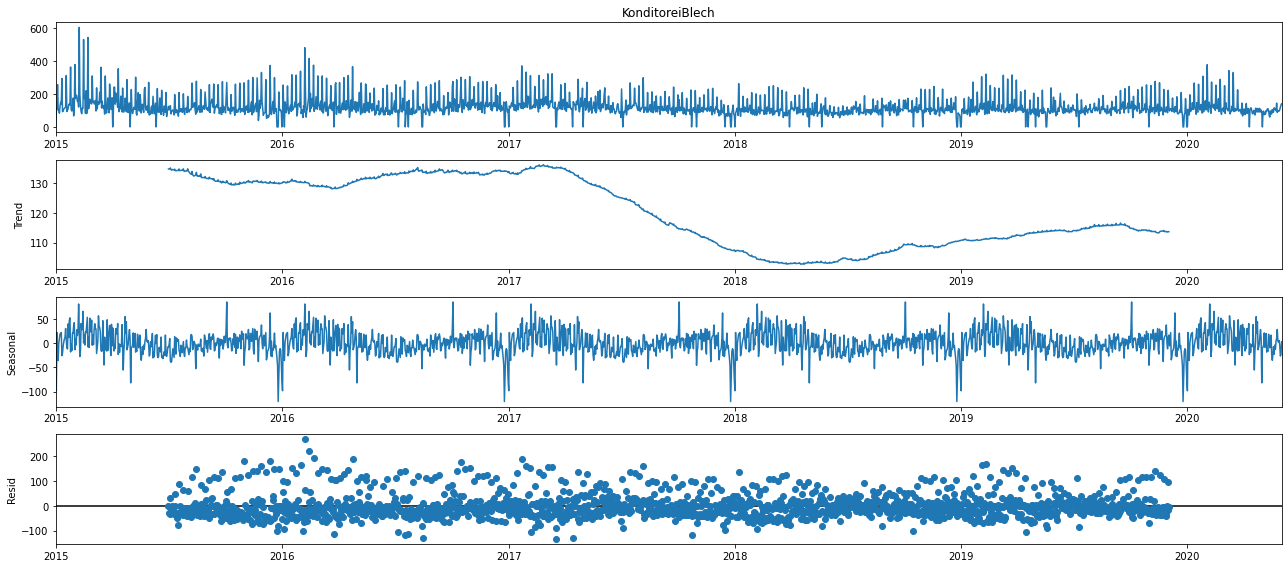

In [136]:
Jahr = 2020
#Decomposition for Filiale 3
y = df_newmodel_3[df_newmodel_3.index.year <= Jahr].KonditoreiBlech

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='aditive',period=365)
fig = decomposition.plot()
       
plt.show()

#### Stückgebäck

**Conclusions**

- `You can see peaks for every New Year's Eve. Inspite of this peaks, the values are rel. constant over the years.`
- `There are weak weekly and yearly patterns within the data.`


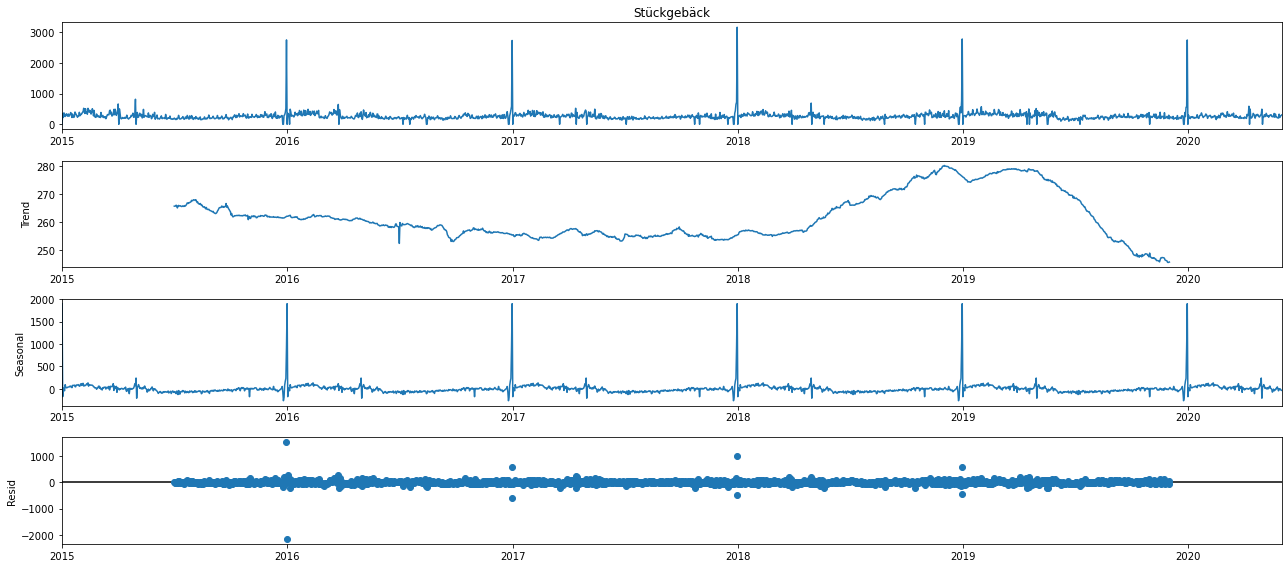

In [137]:
Jahr = 2020
#Decomposition for Filiale 3
y = df_newmodel_3[df_newmodel_3.index.year <= Jahr].Stückgebäck

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='aditive',period=365)
fig = decomposition.plot()
       
plt.show()

#### Blechkuchen

**Conclusions**
- `The is a longterm trend which can be seen for period=365. The sales volumne increases since 2018.`
- `There are weekly and yearly patterns within the data.`


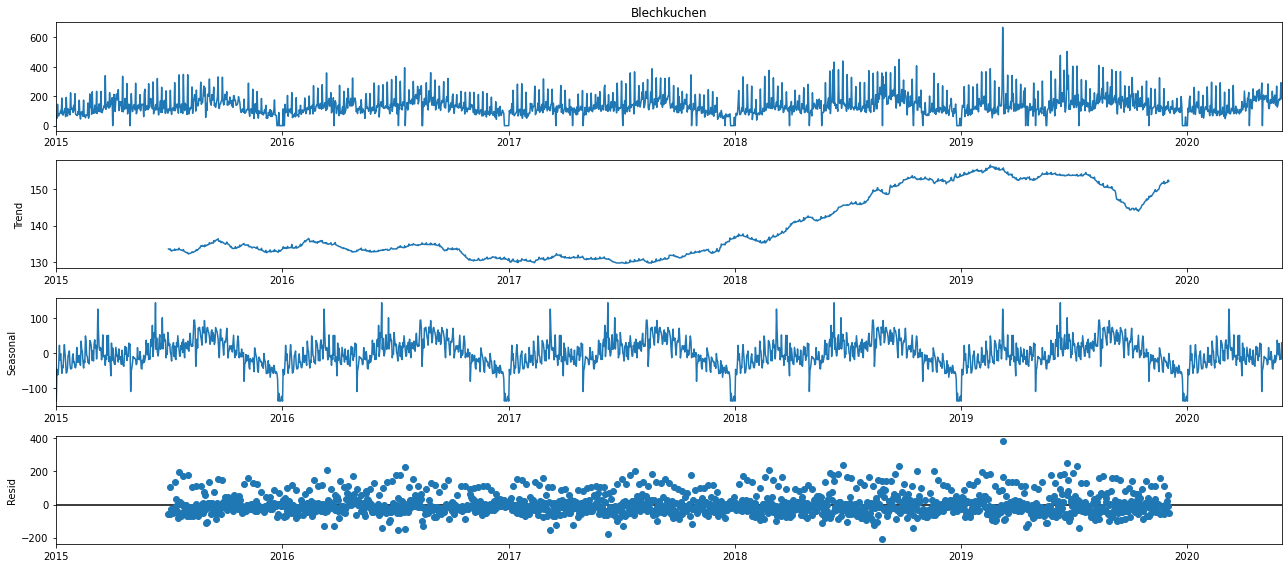

In [138]:
Jahr = 2020
#Decomposition for Filiale 3
y = df_newmodel_3[df_newmodel_3.index.year <= Jahr].Blechkuchen

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='aditive',period=365)
fig = decomposition.plot()
       
plt.show()

#### Weihnachtsartikel

**Conclusions**
- `The is a longterm trend which can be seen for period=365. The sales volumne increases since 2017.`
- `There are hugh yearly patterns within the data, which does not surprise.`


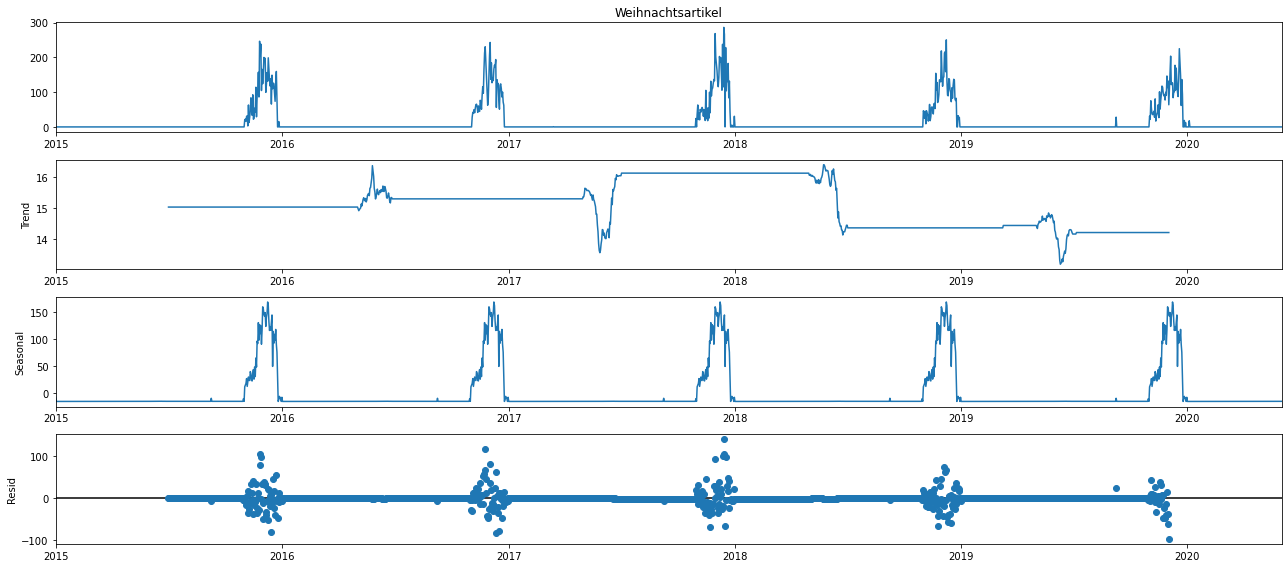

In [139]:
Jahr = 2020
#Decomposition for Filiale 3
y = df_newmodel_3[df_newmodel_3.index.year <= Jahr].Weihnachtsartikel

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='aditive',period=365)
fig = decomposition.plot()
       
plt.show()

## Lag Plots

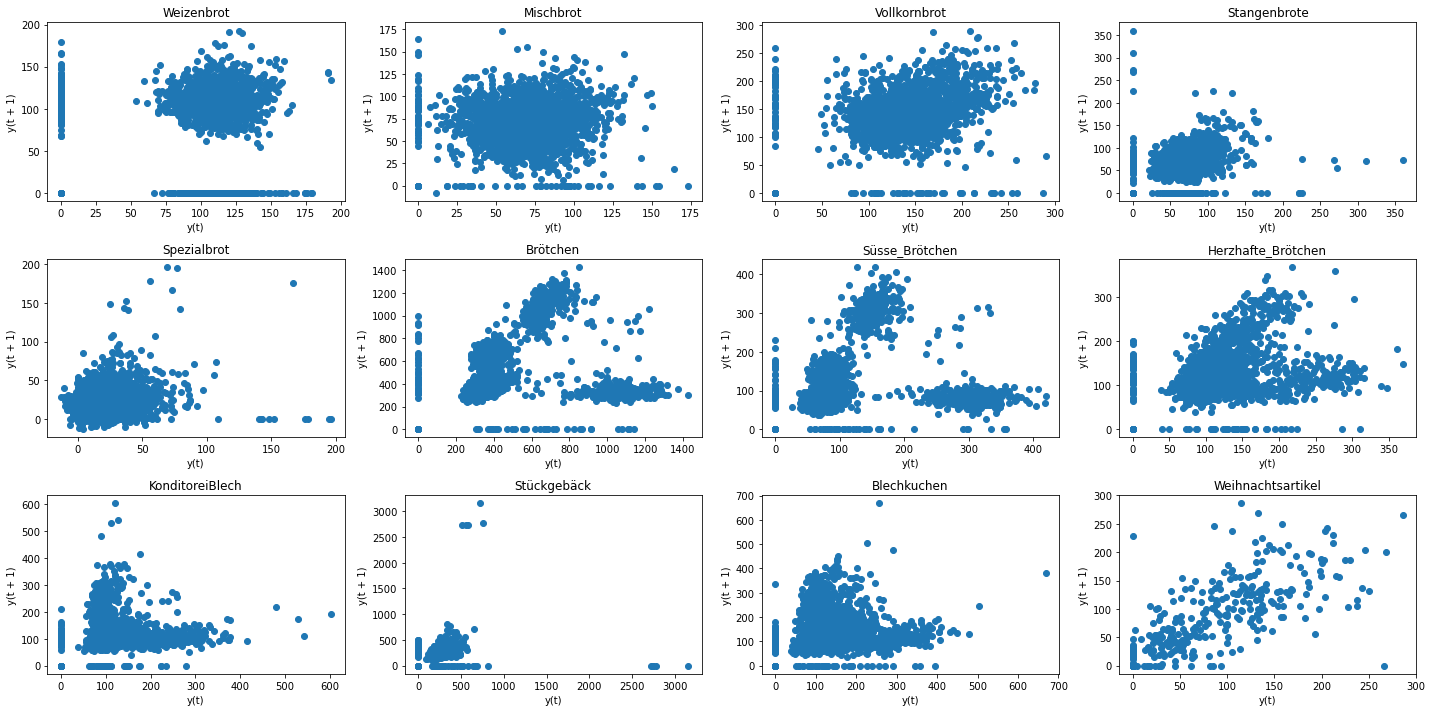

In [140]:
# Make the graph 20 inches by 10 inches
plt.figure(figsize=(20,10), facecolor='white')

# plot numbering starts at 1, not 0
plot_number = 1
for name in df_basis_3.columns:

    ax = plt.subplot(3, 4, plot_number)
    lag_plot(df_basis_3['%s' % (name)],ax=ax)
    ax.set_title(name)
    # Go to the next plot for the next loop
    plot_number = plot_number + 1
plt.tight_layout()

## Autocorrelation Plots

### for Filiale 2

In [141]:

y_3_gesamt=df_newmodel_3.Gesamt[:'15.03.2020']


**Conclusions**
- `From the plot you can see there is a high peak in correlation at the lag of 7th day, then again on the 14th day
and so on. The series is perfectly autocorrelated with a lag of 1 week.`
- `This is valid for all single articlegroups with the exception Weihnachtsartikel. See single plots.`
- `For all articlegroups except Brot(Vollkornbrot, Weizenbrot,..) you see a  peak in correlation at the lag of 365th day.`


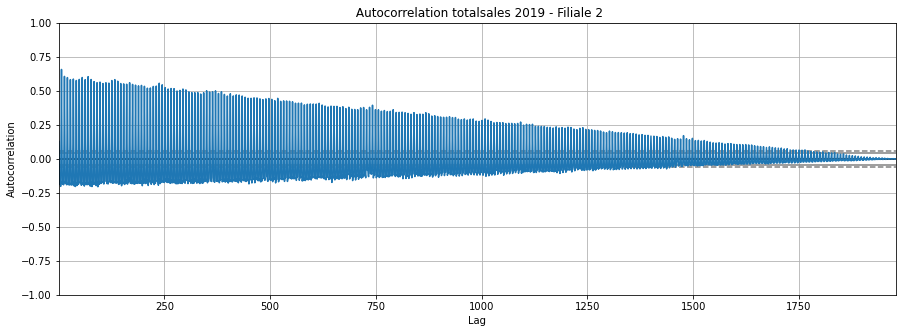

In [142]:
# Autocorrelation totalsales  - Filiale 3
from pandas.plotting import autocorrelation_plot
plt.figure(figsize=(15,5))
autocorrelation_plot(df_new_3.Gesamt).set_title(" Autocorrelation totalsales 2019 - Filiale 2")
plt.show()

In [95]:
#fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,5))
#fig.suptitle('AC and PAC for Filiale 2')
#sm.graphics.tsa.plot_acf(df_new_2.Gesamt.squeeze(), lags=20, ax=ax1)
#sm.graphics.tsa.plot_pacf(df_new_2.Gesamt.squeeze(), lags=20, ax=ax2)
#plt.show()


### For Filiale 3 on Articlegroups

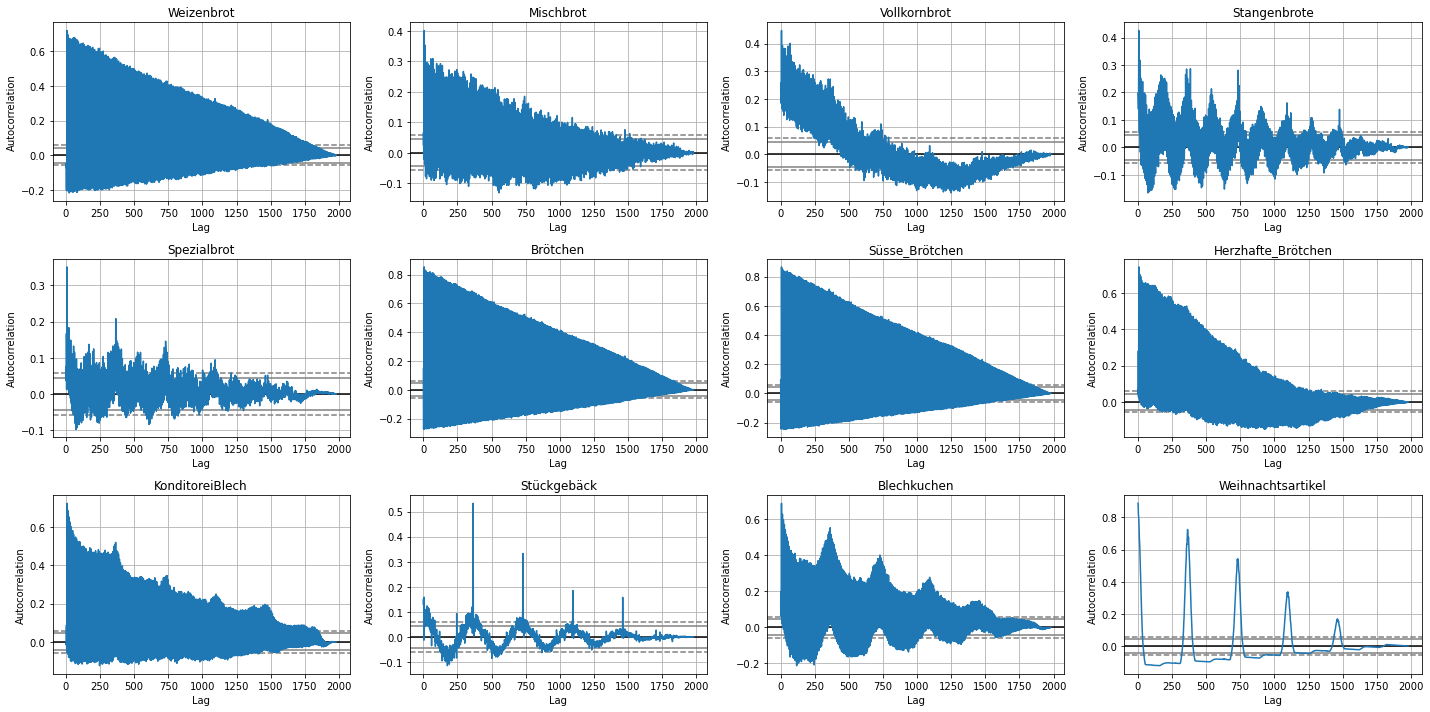

In [143]:
# Analyse weekly dependencies
plt.figure(figsize=(20,10), facecolor='white')

# plot numbering starts at 1, not 0
plot_number = 1
for name in df_basis_3.columns:

    ax = plt.subplot(3, 4, plot_number)
    autocorrelation_plot(df_basis_3['%s' % (name)],ax=ax)
    ax.set_title(name)
    # Go to the next plot for the next loop
    plot_number = plot_number + 1
plt.tight_layout()

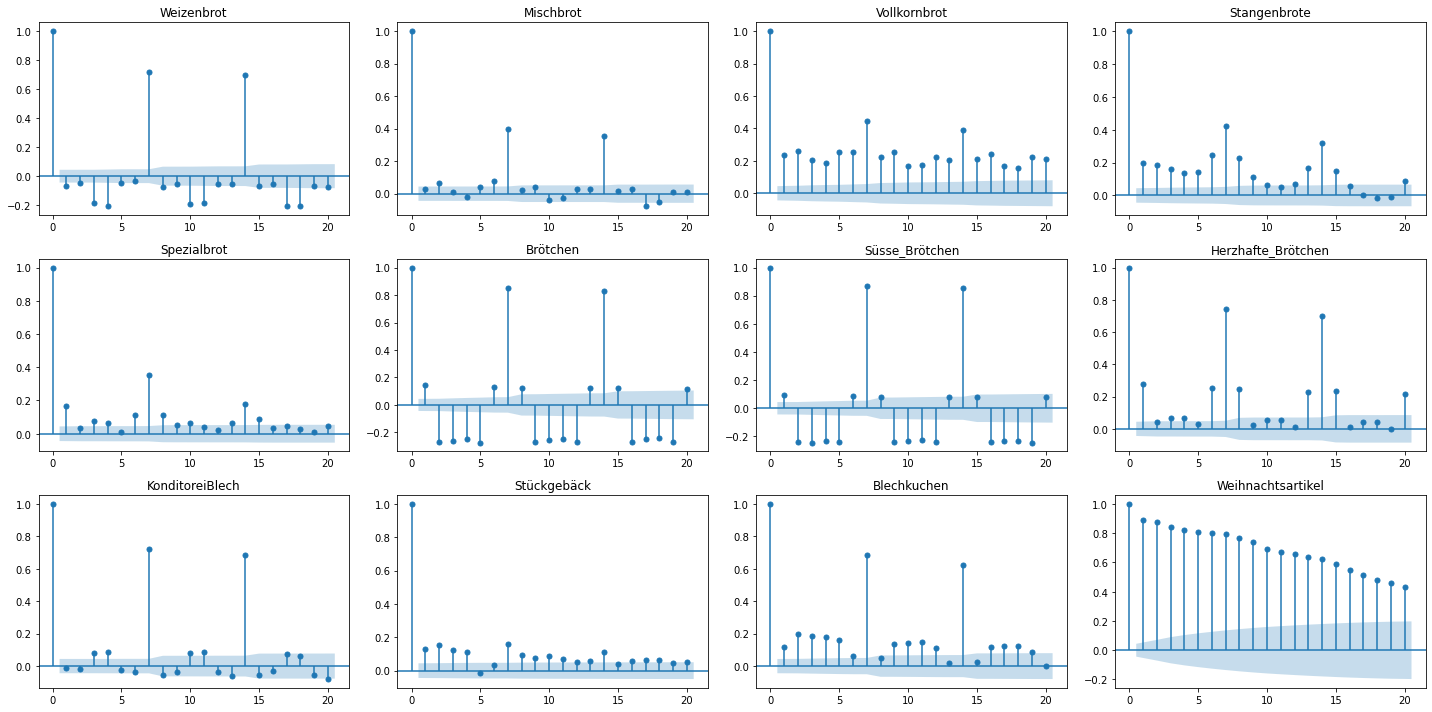

In [144]:
# Analyse weekly dependencies - ACF
plt.figure(figsize=(20,10), facecolor='white')

# plot numbering starts at 1, not 0
plot_number = 1
for name in df_basis_3.columns:

    ax = plt.subplot(3, 4, plot_number)
    plot_acf(df_basis_3['%s' % (name)],lags=20,ax=ax)
    ax.set_title(name)
    # Go to the next plot for the next loop
    plot_number = plot_number + 1
plt.tight_layout()

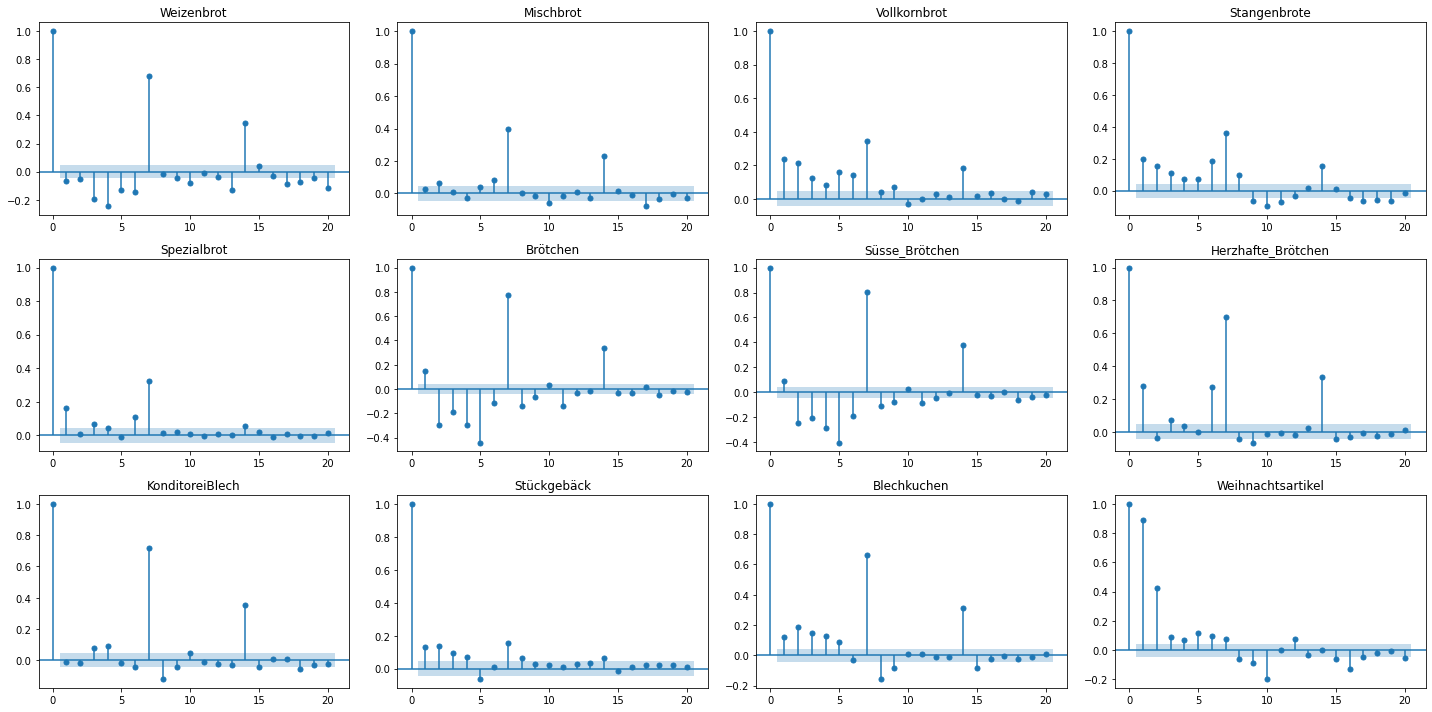

In [145]:
# Analyse weekly dependencies - PACF
plt.figure(figsize=(20,10), facecolor='white')

# plot numbering starts at 1, not 0
plot_number = 1
for name in df_basis_3.columns:

    ax = plt.subplot(3, 4, plot_number)
    plot_pacf(df_basis_3['%s' % (name)],lags=20,ax=ax)
    ax.set_title(name)
    # Go to the next plot for the next loop
    plot_number = plot_number + 1
plt.tight_layout()

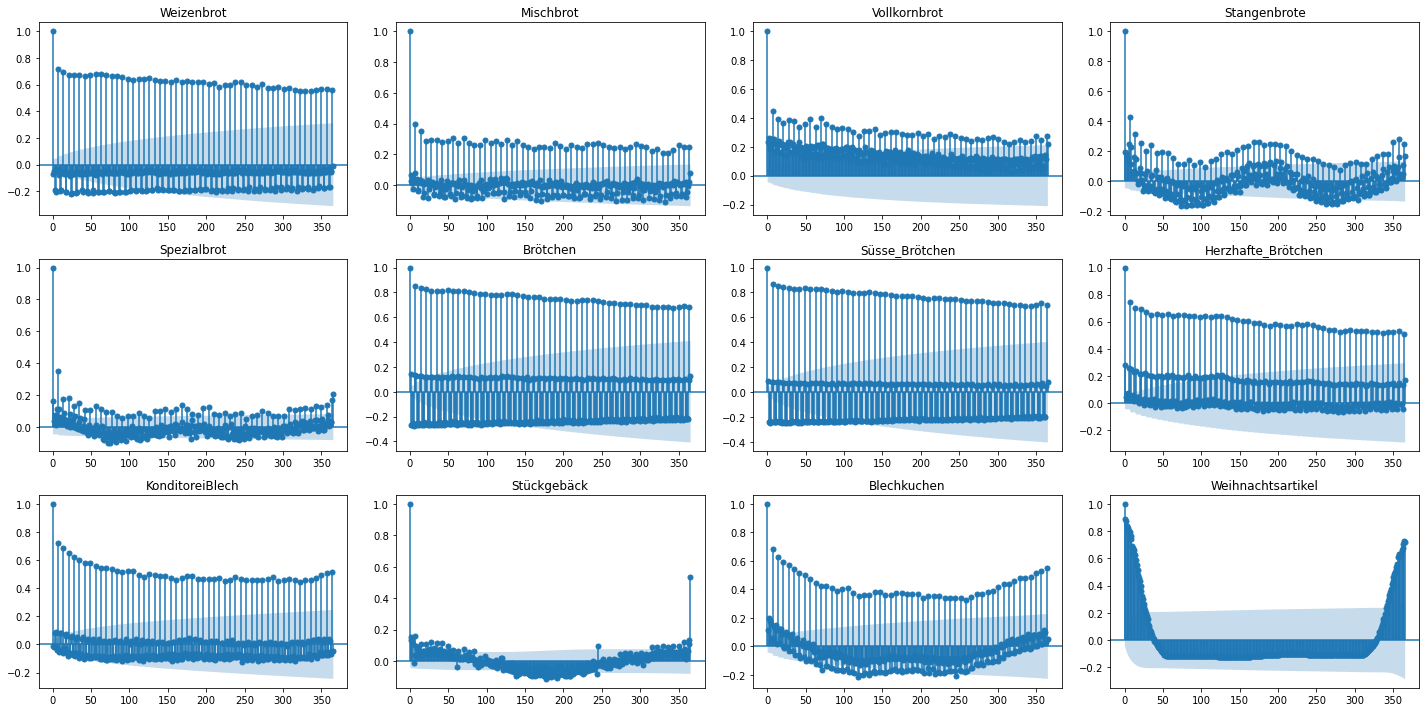

In [146]:
# Analyse yearly dependencies - ACF
plt.figure(figsize=(20,10), facecolor='white')

# plot numbering starts at 1, not 0
plot_number = 1
for name in df_basis_3.columns:

    ax = plt.subplot(3, 4, plot_number)
    plot_acf(df_basis_3['%s' % (name)],lags=365,ax=ax)
    ax.set_title(name)
    # Go to the next plot for the next loop
    plot_number = plot_number + 1
plt.tight_layout()

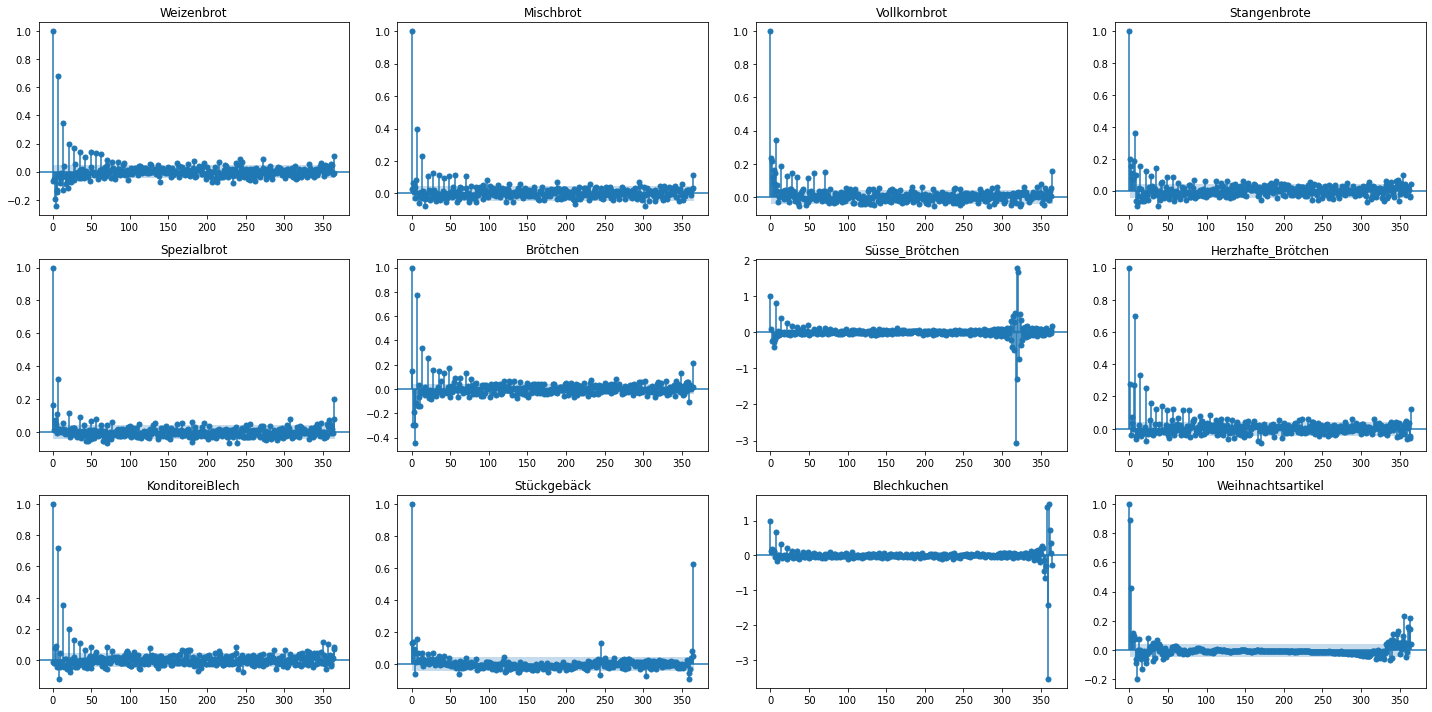

In [147]:
# Analyse yearly dependencies - PACF
plt.figure(figsize=(20,10), facecolor='white')

# plot numbering starts at 1, not 0
plot_number = 1
for name in df_basis_3.columns:

    ax = plt.subplot(3, 4, plot_number)
    plot_pacf(df_basis_3['%s' % (name)],lags=365,ax=ax)
    ax.set_title(name)
    # Go to the next plot for the next loop
    plot_number = plot_number + 1
plt.tight_layout()

## Check Stationarity

- `The couple of series are not stationary. To use VARIMA/VARIMAX  all of the Series needs to be stationary.`
- `After 1 time differentiation all of  the series are difference-stationary / Typ I(1).`

**Conclusions**
- `None of the series is stationary. To use ARIMA or VARIMA/VARIMAX I need to use differencing the Series.`
- `This need to be done one or more times per series with the result that the series is  difference-stationary.`
- `The number of transformations which have to be done can be estimated via auto arima. See next section.`


In [112]:
#df_basis_3_cut

In [148]:
#Apply Check to timeseries of Filiale 1
for name in df_basis_3.columns:
    adf_test_long(df_basis_3[name])
    

Ergebnis für Timeseries Mischbrot:
Test Statistic            -2.808407
p-value                    0.057083
# Lags                    97.000000
# Observations          1881.000000
Critical Value (1%)       -3.433831
Critical Value (5%)       -2.863078
Critical Value (10%)      -2.567589
dtype: float64
 Series is Non-Stationary
Ergebnis für Timeseries Vollkornbrot:
Test Statistic            -1.399327
p-value                    0.582599
# Lags                    69.000000
# Observations          1909.000000
Critical Value (1%)       -3.433780
Critical Value (5%)       -2.863055
Critical Value (10%)      -2.567577
dtype: float64
 Series is Non-Stationary
Ergebnis für Timeseries Süsse_Brötchen:
Test Statistic            -2.679679
p-value                    0.077621
# Lags                   140.000000
# Observations          1838.000000
Critical Value (1%)       -3.433913
Critical Value (5%)       -2.863114
Critical Value (10%)      -2.567608
dtype: float64
 Series is Non-Stationary
Ergebnis

In [149]:
#Apply Check to timeseries of Filiale 2
for name in df_basis_3.columns:
    adf_test(df_basis_3[name])
    

 Ergebnis für Timeseries Weizenbrot: Series is Stationary
Ergebnis für Timeseries Mischbrot: Series is Non-Stationary
Ergebnis für Timeseries Vollkornbrot: Series is Non-Stationary
 Ergebnis für Timeseries Stangenbrote: Series is Stationary
 Ergebnis für Timeseries Spezialbrot: Series is Stationary
 Ergebnis für Timeseries Brötchen: Series is Stationary
Ergebnis für Timeseries Süsse_Brötchen: Series is Non-Stationary
Ergebnis für Timeseries Herzhafte_Brötchen: Series is Non-Stationary
 Ergebnis für Timeseries KonditoreiBlech: Series is Stationary
Ergebnis für Timeseries Stückgebäck: Series is Non-Stationary
 Ergebnis für Timeseries Blechkuchen: Series is Stationary
 Ergebnis für Timeseries Weihnachtsartikel: Series is Stationary


In [150]:
for name in df_basis_3_cut.columns:
    adf_test(df_basis_3_cut[name])

 Ergebnis für Timeseries Weizenbrot: Series is Stationary
Ergebnis für Timeseries Mischbrot: Series is Non-Stationary
Ergebnis für Timeseries Vollkornbrot: Series is Non-Stationary
 Ergebnis für Timeseries Stangenbrote: Series is Stationary
 Ergebnis für Timeseries Spezialbrot: Series is Stationary
Ergebnis für Timeseries Brötchen: Series is Non-Stationary
Ergebnis für Timeseries Süsse_Brötchen: Series is Non-Stationary
Ergebnis für Timeseries Herzhafte_Brötchen: Series is Non-Stationary
 Ergebnis für Timeseries KonditoreiBlech: Series is Stationary
Ergebnis für Timeseries Stückgebäck: Series is Non-Stationary
 Ergebnis für Timeseries Blechkuchen: Series is Stationary
 Ergebnis für Timeseries Weihnachtsartikel: Series is Stationary


In [151]:
for name in df_basis_3.columns:
    adf_test(df_basis_3[name].diff().dropna())

 Ergebnis für Timeseries Weizenbrot: Series is Stationary
 Ergebnis für Timeseries Mischbrot: Series is Stationary
 Ergebnis für Timeseries Vollkornbrot: Series is Stationary
 Ergebnis für Timeseries Stangenbrote: Series is Stationary
 Ergebnis für Timeseries Spezialbrot: Series is Stationary
 Ergebnis für Timeseries Brötchen: Series is Stationary
 Ergebnis für Timeseries Süsse_Brötchen: Series is Stationary
 Ergebnis für Timeseries Herzhafte_Brötchen: Series is Stationary
 Ergebnis für Timeseries KonditoreiBlech: Series is Stationary
 Ergebnis für Timeseries Stückgebäck: Series is Stationary
 Ergebnis für Timeseries Blechkuchen: Series is Stationary
 Ergebnis für Timeseries Weihnachtsartikel: Series is Stationary


## Check Causality

**Conclusions**
- `Looking at the p-Values we can assume that almost all variables are interchangeably each user.`
- `A exception is the articlegroup Blechkuchen.`
- `Overall this justifies an multivariate approach for prediction.`

In [ ]:
maxlag=12
test = 'ssr-chi2test'

def grangers_causality_matrix(X_train, variables,Filiale, test = 'ssr_chi2test', verbose=False):
   dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
   for c in dataset.columns:
    for r in dataset.index:
        test_result = grangercausalitytests(X_train[[r,c]], maxlag=maxlag, verbose=False)
        p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
        if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
        min_p_value = np.min(p_values)
        dataset.loc[r,c] = min_p_value
        
    dataset.columns = [var + '_x_'+ Filiale for var in variables]
    dataset.index = [var + '_y' for var in variables]

    return dataset


In [153]:
df_basisnew_3=df_newmodel_3.iloc[:,0:12]

In [154]:
result_3=grangers_causality_matrix(df_basisnew_3, df_basisnew_3.columns,Filiale='Filiale_3')


## Cointegrationtest

In [155]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [156]:
cointegration_test(df_basisnew_3)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Weizenbrot ::  2262.34   > 311.1288  =>   True
Mischbrot ::  1434.32   > 263.2603  =>   True
Vollkornbrot ::  1124.25   > 219.4051  =>   True
Stangenbrote ::  881.74    > 179.5199  =>   True
Spezialbrot ::  687.3     > 143.6691  =>   True
Brötchen ::  509.07    > 111.7797  =>   True
Süsse_Brötchen ::  346.62    > 83.9383   =>   True
Herzhafte_Brötchen ::  223.43    > 60.0627   =>   True
KonditoreiBlech ::  121.76    > 40.1749   =>   True
Stückgebäck ::  55.23     > 24.2761   =>   True
Blechkuchen ::  25.93     > 12.3212   =>   True
Weihnachtsartikel ::  1.34      > 4.1296    =>   False
